# 链接仪器

In [138]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np, sympy as sy, visa
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from easydl import clear_output
from sklearn.cluster import KMeans
from configparser import ConfigParser
from qulab import optimize, measureroutine_population, computewave_wave, imatrix, waveform_new, measureroutine, computewave, dataTools
# from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
opt = imp.reload(opt)
op = imp.reload(optimize)
mrw = imp.reload(measureroutine_population)
cww = imp.reload(computewave_wave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
dt = imp.reload(dataTools)
# mr = imp.reload(measureroutine)
# cw = imp.reload(computewave)
# mn = imp.reload(measureroutine_new)
# wf = imp.reload(wavepoint)

In [130]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
afg= await connect('AFG')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
# ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
# psg104 = await connect('PSG104')
# psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
afg = await connect('AFG')
# att3 = await connect('Att3')
# att4 = await connect('Att4')
# att5 = await connect('Att5')
# att6 = await connect('Att6')
# att7 = await connect('Att7')
# att8 = await connect('Att8')
# att9 = await connect('Att9')
# # #pna = await connect('PNA')

In [14]:
await awg133.query('*IDN?')

'TEKTRONIX,AWG5208,B010153,FV:6.1.0054.0\n'

# redis测试

In [75]:
import redis

# 普通连接
conn = redis.Redis(host="10.122.7.20",port=6379)
conn.set("x1","hello",ex=1) # ex代表seconds，px代表ms
val = conn.get("x1")
print(val)

b'hello'


In [4]:
# rm = visa.ResourceManager()
# awg133 = rm.open_resource('TCPIP::10.122.7.133')
# x = awg133.query('*IDN?')

# 设置TrigB

In [4]:
await afg.reset()
await asyncio.sleep(2)
await afg.setValue('Output','ON',ch=1)
await afg.setValue('Function','Pulse',ch=1)
await afg.setValue('Pulse Period',110e-6,ch=1)
await afg.setValue('Pulse Width',1e-6,ch=1)
await afg.setValue('Amplitude',5,ch=1)
await afg.setValue('Offset',0,ch=1)

In [18]:
for i in range(20):
    await awg100.stop()
    await afg.write('*TRG')
    await awg100.run()
    time.sleep(1)

# qubit工作点

In [4]:
# freqall = np.array([6.505,6.517,6.53,6.542,6.559,6.571,6.587,6.601,6.6045,6.63])*1e9
# freqall = np.array([6.451,6.466,6.478,6.494,6.51,6.508,6.516,6.534,6.563,6.576])*1e9
freqall = np.array([6.545, 6.564, 6.588, 6.608, 6.63, 6.642, 6.649, 6.689, 6.71, 6.73])*1e9
# freqall = freqall[::-1]
f_cavity = {'q%d'%(i):j for i, j in enumerate(freqall,start=1)}

In [171]:
measure.freqall = f_cavity

In [55]:
measure.jpa = jpa

In [195]:
jpa = mrw.qubit(q_name='jpa',inst={'dc':'dc15','pump':'psg_pump'},bias=-0.825,f_ex=2*6.76e9+2e6,power_ex=4.73) #power=-2.1 

In [54]:
jpa = mrw.qubit(q_name='jpa',inst={'dc':'dc15','pump':'psg_pump'},bias=-1.397,f_ex=2*6.74e9+2e6,power_ex=7.34)

In [5]:
jpa = mrw.qubit(q_name='jpa',inst={'dc':'dc15','pump':'psg_pump'},bias=-1.428,f_ex=2*6.75e9+2e6,power_ex=5.24)

In [ ]:
jpa = mrw.qubit(q_name='jpa',inst={'dc':'dc15','pump':'psg_pump'},bias=-1.137,f_ex=2*6.755e9+2e6,power_ex=4.8)

## 保存工作点

In [134]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i.asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name\wave')
with open(r'D:\skzhao\file_name\qubit_state_wave.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\wave\2020\1113\QubitState\qubitstate_20201113140554.npz


In [3]:
import numpy as np
0 << 2

0

## 提取工作点

In [139]:
fl = np.loadtxt(r'D:\skzhao\file_name\qubit_state_wave.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    for i,k in enumerate(q):
        attr = {}
        for j in mrw.qubit().asdict():
            if j in k:
                attr[j] = k[j]
            else:
                attr[j] = None
        globals()[k['q_name']] = mrw.qubit(**attr)

dict2tuple(data['state'])
print(f)



D:\skzhao\file_name\wave\2020\1113\QubitState\qubitstate_20201113140554.npz


In [133]:
q1.asdict()

{'q_name': 'q1',
 'inst': {'z_awg': 'awg132',
  'z_ch': [1],
  'ex_awg': 'awg134',
  'ex_ch': [4, 8],
  'ex_lo': 'psg_ex1',
  'com': 'com3'},
 'T_bias': [3.345, -0.284],
 'T_z': [2.101, -0.194],
 'specinterp': None,
 'specfunc': 5.25149015598707*(0.942356245310643*tan(0.934656305237647*x + 0.218709575425609)**2 + 1)**(1/4)*sqrt(Abs(cos(0.934656305237647*x + 0.218709575425609))) - 0.81966338969257,
 'specfuncz': None,
 'specfunc_cavity': sqrt((5.25149015598707*(0.942356245310643*tan(0.934656305237647*x + 0.218709575425609)**2 + 1)**(1/4)*sqrt(Abs(cos(0.934656305237647*x + 0.218709575425609))) - 7.33303642022885)**2 + 0.268557160758026)/2 + 2.62574507799353*(0.942356245310643*tan(0.934656305237647*x + 0.218709575425609)**2 + 1)**(1/4)*sqrt(Abs(cos(0.934656305237647*x + 0.218709575425609))) + 2.84685482042185,
 'photonnum_func': None,
 'bias': 0,
 'zpulse': None,
 'f_lo': array([6.535e+09]),
 'delta': array([50000000.]),
 'f_ex': 4790000000.000097,
 'delta_ex': 200000000.0,
 'alpha': 2080

In [141]:
measure.qubits['q8'].asdict()

{'q_name': 'q8',
 'inst': {'z_awg': 'awg132',
  'z_ch': [7],
  'ex_awg': 'awg133',
  'ex_ch': [3, 7],
  'ex_lo': 'psg_ex1',
  'com': 'com3'},
 'T_bias': [3.088, -0.412],
 'T_z': [3.06, -0.538],
 'specinterp': [array([4.94499027, 4.94499727, 4.94500427, ..., 5.80383735, 5.80383743,
         5.80383752]),
  array([-0.5       , -0.49999808, -0.49999616, ..., -0.02000384,
         -0.02000192, -0.02      ])],
 'specfunc': 2.5746352620322*(0.745827234020123*tan(1.00339082454598*x + 0.108366209050966)**2 + 1)**(1/4)*sqrt(Abs(cos(1.00339082454598*x + 0.108366209050966))) - 0.630024124629741,
 'specfuncz': [6.16180248305786*(9.65756554295829e-5*tan(1.51488370449607*x + 0.0205973737091457)**2 + 1)**(1/4)*sqrt(Abs(cos(1.51488370449607*x + 0.0205973737091457))) - 0.357820026766172,
  -0.013596669927872444,
  2.0738177090860286,
  13.263584693454405,
  0.3578200267661721,
  0.009827291357723292],
 'specfunc_cavity': sqrt((2.5746352620322*(0.745827234020123*tan(1.00339082454598*x + 0.10836620905096

In [140]:
qubitlist = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
measure.qubits= {i.q_name:i for i in qubitlist}

# 提取IQ-Mixer配置参数

In [258]:
fl = np.loadtxt(r'D:\skzhao\file_name\iqmixer_state.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)

atributte = ['q_name','alpha_read','alpha_ch1','alpha_ch2','alpha_ch3','alpha_ch4','alpha_ch5',\
            'beta_read','beta_ch1','beta_ch2','beta_ch3','beta_ch4','beta_ch5']
Iqmixer = namedtuple('Iqmixer',atributte,defaults=[{} for i in range(12)])

iqm = Iqmixer(q_name='Iqm') #power=-2.1

def dict2tuple(q):
    global iqm
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        iqm = Iqmixer(*attr)

dict2tuple(data['state'])
# print(f,iqm)

In [260]:
iqm.beta_read

{'6.632150': array([ 0.002, -0.005]), '6.759000': array([ 0.001, -0.008])}

In [261]:
ch_I, ch_Q, offset_I, offset_Q = 1,5,0.001, -0.008
awg = awg133
await awg.setValue('Offset',offset_I,ch=ch_I)
await awg.setValue('Offset',offset_Q,ch=ch_Q)

## 保存提取全局变量

In [433]:
cw.saveStatus(fname='D:/status.obj')

In [5]:
cw.loadStatus(fname='D:/status.obj')

# 初始化变量

In [86]:
onwhich, offwhich = {}, {}
predict, readmatrix = {}, {}

# 指定仪器

In [8]:
psg_lo = psg105
psg_ex1 = psg106
psg_trans = psg230
# psg_ex2 = psg106
# psg_ex3 = psg103
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_trans':psg_trans,'psg_pump':psg_pump}
ats = ats18
dc = {'q8':dc01,'q6':dc02,'q3':dc11,'q5':dc03,'q4':dc08,\
      'q9':dc07,'q2':dc10,'q7':dc06,'jpa':dc15,'q10':dc05,'q1':dc20}
#awg = awg132
# attinst = {'com3':att3,'com4':att4,'com5':att5,'com6':att6,'com7':att7,'com8':att8,'com9':att9}
attinst={}
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg133,'awg134':awg134,'awgread':awg133,'awg_trig':awg133,'awg_trig100':awg100}

In [333]:
measure.awg = awg_list

In [15]:
measure.dc = dc

## 测量类

In [9]:
measure = mrw.common(f_cavity,ats,dc,psg,awg_list,attinst,jpa,[q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

# 初始化及同步AWG

In [12]:
await mrw.resetAwg(awg_list)

In [14]:
await mrw.awgSync(measure)

In [94]:
with open(r'D:\QuLabData\awgGui\state.txt', mode='w') as filename:
    filename.write('[5,0,75,65]')
    filename.write('\n') 

In [56]:
x = np.loadtxt(r'D:\QuLabData\awgGui\state.txt',delimiter=',',dtype=str)

# 信号检查

In [43]:
# delta = np.array([1.75e+08, 1.62e+08, 1.49e+08, 1.36e+08, 1.21e+08, 1.07e+08,
#        9.30e+07, 8.00e+07, 7.50e+07, 5.00e+07])
# f_lo, delta, n = await mr.resn(f)
# delta = measure.delta
delta = np.array([50e6])
await cww.modulation_read(measure,delta,readlen=1200)
# await mr.ats_setup(ats,delta,l=180+128)
await awg133.run()
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

In [127]:
f_list = await ats.getValue('repeats')
f_list

3008

## 读出信号相位噪声

Output()

<IPython.core.display.Javascript object>


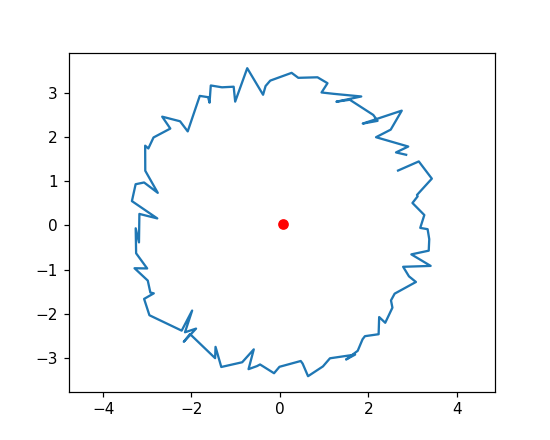

In [178]:
phase = np.linspace(0,2*np.pi,101)
job = Job(mrw.rPhase, (measure,phase), tags=['phase noise'], max=len(phase))
pp, sp = await job.done()
plt.figure(figsize=(5,4))
plt.plot(np.real(sp[:,0]),np.imag(sp[:,0]))
plt.plot(np.mean(np.real(sp[:,0])),np.mean(np.imag(sp[:,0])),'ro')
plt.axis('equal')
plt.show()

In [34]:
f_list = await ats.setValue('repeats',201)

In [70]:
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

In [76]:
await psg_lo.setValue('Frequency',6.56e9)

## 复平面信号

<IPython.core.display.Javascript object>


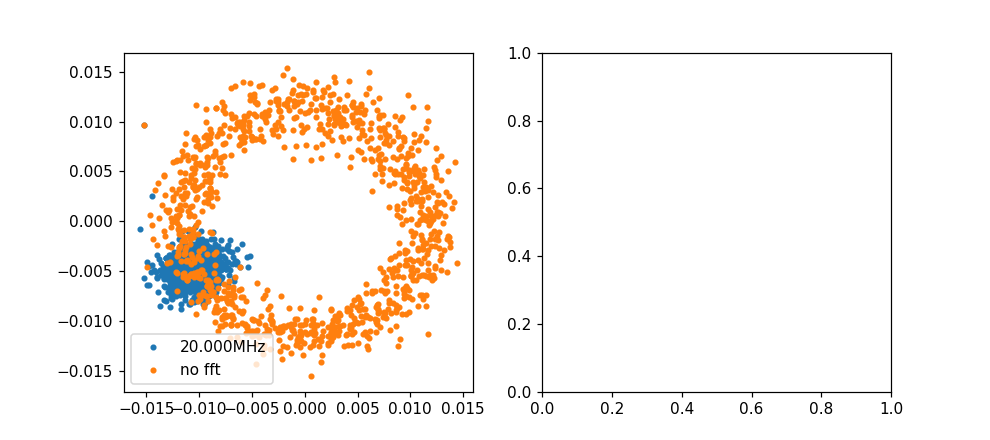

In [133]:

I, Q = 0, 0
await psg_lo.setValue('Output','ON')
await psg_ex1.setValue('Output','OFF')
# await mrw.jpa_switch(measure,state='OFF')
f_list = np.array(await ats.getValue('f_list'))
for i in range(1):
    chA, chB, ch_I, ch_Q = await ats.getTraces(fft=False,avg=True,hilbert=True,is2ch=False,offset=True)
    I += chA
    Q += chB
s, e, h = (I+1j*Q), [], len(f_list)//2+len(f_list)%2
t = np.arange(0, len(s), 1) / 1e9

fig, axes = plt.subplots(ncols=2,nrows=h,figsize=(9,4*h))
for i,f in enumerate(f_list):
    em = np.exp(-1j * 2 * np.pi * f * t)
    e.append(em)
    if h == 1:
        axes[i].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i].legend(loc="lower left")
    else:
        axes[i//2][i%2].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i//2][i%2].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i//2][i%2].legend(loc="lower left")

plt.show()

## 时域信号

<IPython.core.display.Javascript object>


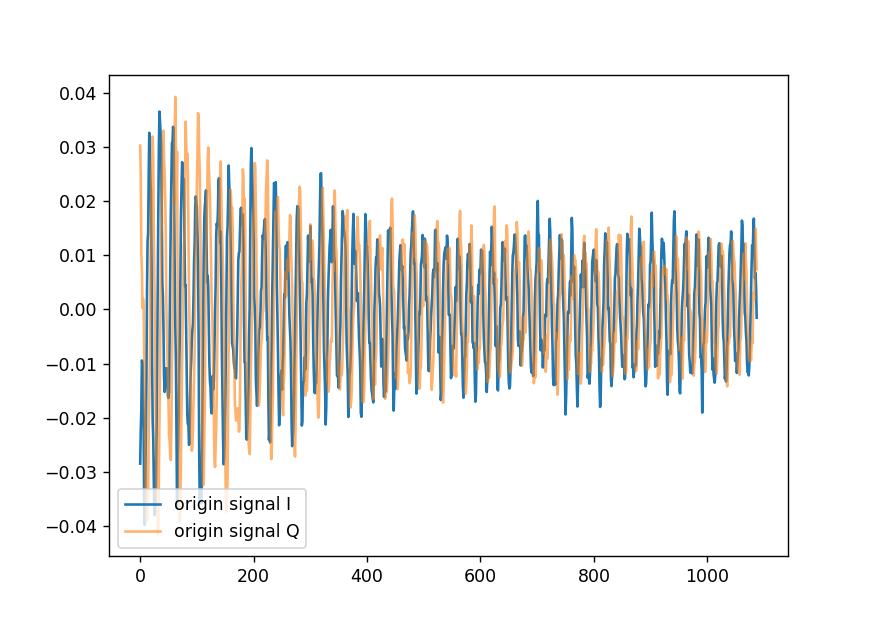

In [431]:
%matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex1'].setValue('Output','OFF')
for i in range(1):
    chA, chB, ch_I, ch_Q = await ats.getTraces(hilbert=False,is2ch=False)
    I += chA
    Q += chB
    
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
# plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),label='envelop')
plt.legend(loc="lower left")
plt.show()

In [118]:
await psg_lo.setValue('Frequency',5e9)

## 频域信号

<IPython.core.display.Javascript object>


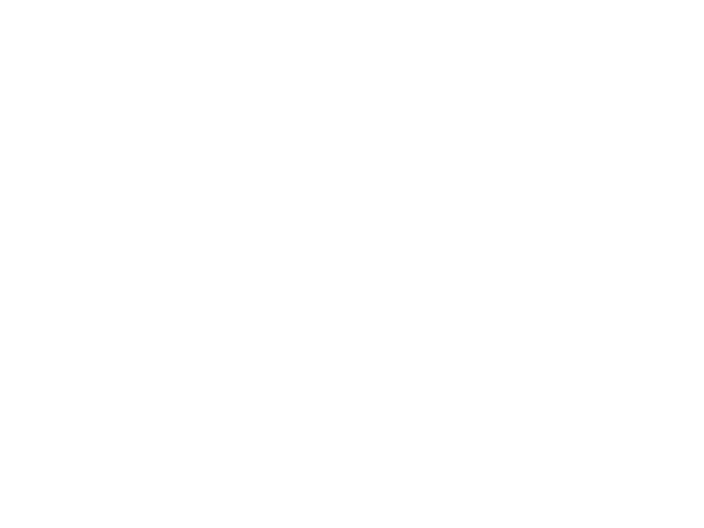

In [239]:
f = np.fft.fftshift(np.fft.fftfreq(len(I)))*1e9
Pxx = np.abs(np.fft.fftshift(np.fft.fft(I + 1j*Q)))
# x, y = np.linspace(0,len(I),len(I))*1e-9, I + 1j*Q
# f, Pxx = op.RowToRipe().spectrum(x,y,method='welch',shift=True)
Delta_list = np.array(await ats.getValue('f_list'))
plt.figure()

plt.vlines(Delta_list/1e6, np.min(Pxx), np.max(Pxx), 'r')

plt.semilogy(f/1e6, Pxx)

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-500,500)
plt.show()

In [247]:
y

3

# 仪器状态

In [144]:
clearseq = [f'awg13{i+1}' for i in range(4)]
clearseq = []
await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=clearseq)

In [19]:
state = await cww.QueryInst(measure)
pd.DataFrame(state)

,q8,q6,q3,q5,q4,q9,q2,q7,jpa,q10,...,psg_lo,psg_ex1,psg_trans,psg_pump,awg131,awg132,awg133,awg134,awgread,awg_trig
ch1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF,OFF
ch2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF,OFF
ch3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF,OFF
ch4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF,OFF
ch5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF,OFF
ch6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF,OFF
ch7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF,OFF
ch8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF,OFF
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,...,0,0,0,0,0,0,0,0,0,0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.779450GHz,4.719397GHz,5.599000GHz,13.482000GHz,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
await cww.RecoverInst(measure,state)

In [346]:
await psg_ex1.setValue('Moutput','OFF')

In [179]:
await psg_lo.setValue('Power',15)

In [18]:
await psg_lo.setValue('Frequency',6.5e9)

In [64]:
measure.delta,measure.base,measure.readlen = q10.state[1:]
await mrw.RecoverInst(measure,state=q10.state[0])

In [18]:
for i in range(2000):
    await awg134.query('syst:err?')

In [17]:
for i in dc:
    await dc[i].setValue('Load','High')

# S21

Output()

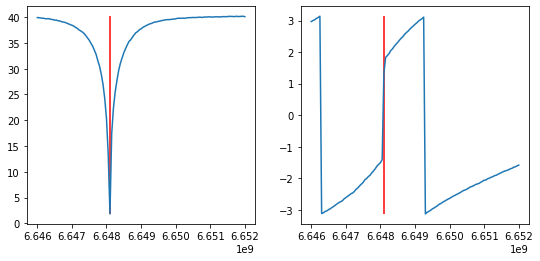

In [66]:
q_target = q1
freq = np.linspace(6,7,1001)*1e9 + 50e6
tag = q_target.q_name
# await measure.attinst['com8'].set_att(38)
await mrw.jpa_switch(measure,state='ON')
# await psg_pump.setValue('Output','OFF')
# await dc15.DC(-3.398)
f_lo, delta, n, f_res,base,f_s21, s_s21 = await mrw.again(q_target,measure,False,measure.f_lo)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[0].vlines(f_lo-delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
axes[1].vlines(f_lo-delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

Output()

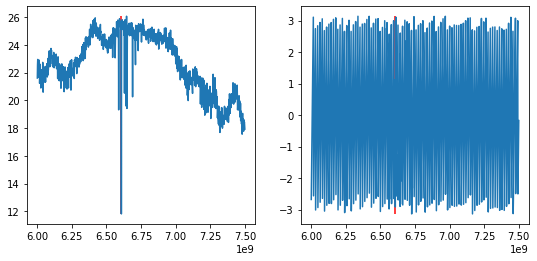

In [128]:
q_target = q1
freq = np.linspace(6,7.5,1001)*1e9 + 50e6
tag = q_target.q_name
# await measure.attinst['com8'].set_att(38)
await mrw.jpa_switch(measure,state='OFF')
# await psg_pump.setValue('Output','OFF')
await dc15.DC(-1.397)
f_lo, delta, n, f_res,base,f_s21, s_s21 = await mrw.again(q_target,measure,False,measure.f_lo,freq)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[0].vlines(f_lo-delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
axes[1].vlines(f_lo-delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [175]:
f_lo-measure.delta

array([6.70905e+09])

# 读取信号强度随时间变化

Output()

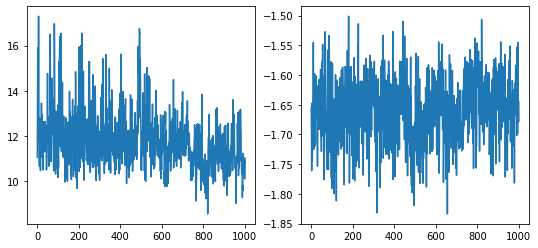

In [28]:
# await measure.attinst['com8'].set_att(20)
await psg_lo.setValue('Output','ON')
# await psg['psg_trans'].setValue('Output','ON')
#await psg[q_target.inst['ex_lo']].setValue('Frequency',f_rabi)
# await mr.jpa_switch(measure,state='OFF')
job = Job(mr.test, (measure,1001), tags=['time varing of signal'], max=1001)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,np.abs(s_s21))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [96]:
np.mean(np.abs(s_s21))/np.std(s_s21)

10.166608793708301

In [15]:
%matplotlib notebook

# S21vsFlux

In [291]:
bits = [q2]
current = np.linspace(-1,1,21)
measure.readamp = [0.03]*10
measure.ringup = [100]*10
measure.ringupamp = [0.06]*10
# await measure.attinst['com8'].set_att(25)
for i in bits:
    tag = i.q_name
    print(i.inst)
    await mrw.jpa_switch(measure,'ON')
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mrw.S21vsFlux_awgoffset, (i,measure,current,None), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [17]:
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
current = np.linspace(-2,2,21)
measure.readamp = 0.6
# await measure.attinst['com8'].set_att(25)
for i in bits:
    tag = i.q_name
    print(i.inst)
    await mrw.jpa_switch(measure,'ON')
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mrw.S21vsFlux, (i,measure,current,None), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await mrw.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [ ]:
calimatrix = np.load(r'D:/QuLabData/2020/0624/crosstalk_cali/q1-q7_20200624171927.npz')['mat']
calimatrix[1:5,1:5]

In [ ]:
calimatrix = np.array([[ 1.        , -0.00614072,  0.00237171,  0.00339285,  0.01229189],
       [ 0.01965284,  1.        , -0.01015246, -0.00295805, -0.00609832],
       [ 0.01144612,  0.02177006,  1.        , -0.01671896, -0.00728347],
       [ 0.01140976,  0.02193547,  0.02581161,  1.        , -0.01872843],
       [ 0.00925843,  0.01711204,  0.01496927,  0.01558848,  1.        ]])

# S21vsPower

In [21]:
measure.readamp = [0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4]
measure.ringup = [0,0,0,0,0,0,0,0,0,100]
measure.ringupamp = [0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8]

In [26]:
q_target, att = q10, np.linspace(0.01,0.36,36)
tag = q_target.q_name
# await mrw.jpa_switch(measure,'ON')
job = Job(mrw.S21vsPower, (q_target,measure,att,'com8'), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

Output()

IndexError: too many indices for array

# singlespce

In [14]:
calimatrix = np.load(r'D:/QuLabData/2020/0624/crosstalk_cali/q1-q7_20200624171927.npz')['mat']
np.mat(calimatrix)

matrix([[ 1.        ,  0.        ,  0.02081242, -0.00556228, -0.03419392,
          0.0722012 ,  0.07923705,  0.        ,  0.        ,  0.        ],
        [-0.11087751,  1.        ,  0.00911005, -0.03760278, -0.02984445,
          0.07501739,  0.08099287,  0.        ,  0.        ,  0.        ],
        [-0.09237872,  0.        ,  1.        , -0.02808258, -0.03020463,
          0.05719553,  0.07826868,  0.        ,  0.        ,  0.        ],
        [-0.09966487,  0.        ,  0.08454681,  1.        , -0.03020463,
          0.05499408,  0.0763224 ,  0.        ,  0.        ,  0.        ],
        [-0.07804834,  0.        ,  0.07193357, -0.06137783,  1.        ,
          0.0501854 ,  0.07041253,  0.        ,  0.        ,  0.        ],
        [-0.08190848,  0.        ,  0.10309907, -0.06923761,  0.04200055,
          1.        ,  0.08362114,  0.        ,  0.        ,  0.        ],
        [-0.06118311,  0.        ,  0.07212722, -0.06237858,  0.03363237,
         -0.02547738,  1.       

In [20]:
q, bias = q1, 0
q.T_bias
q.T_bias[1]-q.T_bias[0]/2
x = sy.Symbol('x')
f_com = np.float(q.specfunc.evalf(subs={x:bias}))
print(round(f_com,3),q.T_bias,q.T_bias[1]-q.T_bias[0]/2)

4.428 [3.364, -0.229, (3.36212491877869, -0.24)] -1.911


In [61]:
q = q8
q.T_bias[1]-q.T_bias[0]/2

-0.9175

In [13]:
q7.inst

{'z_awg': 'awg132',
 'z_ch': [8],
 'ex_awg': 'awg134',
 'ex_ch': [2, 6],
 'ex_lo': 'psg_ex1',
 'com': 'com3'}

In [239]:
q3.replace(envelopename=['hanning',2],nwave=1,readamp=0.25,amp=1,shift=0e-9,phase=0,phaseDiff=0,timing={'z>xy':0e-9,'read>xy':0e-9},zCali=None)

In [142]:
q4.T_bias

[2.674, 0.19]

In [56]:
q10.ringupamp = 0.15

In [145]:
q_target = q1
dcstate = {}
# dcstate = {i: round(measure.qubits[i].T_bias[1]+measure.qubits[i].T_bias[0]/5.3,3) for i in measure.qubits}
# dcstate['q8'] = 0.35
# dcstate['q10'] = -0.3
dcstate['q4'] = -0.51
# measure.readamp = [0.03]
# measure.ringup = [100]
# measure.ringupamp = [0.06]
measure.readamp = [0.03]
measure.ringup = [100]
measure.ringupamp = [0.1]
await mrw.dcManage(measure,dcstate=dcstate,readstate=[],calimatrix=None)

task = await mrw.executeZwave(measure,cww.zWave,dcstate={},output=True,during=0/1e9,shift=3000e-9)
mrw.concurrence(task)

# zname, zch = [f'ch{i}' for i in q_target.inst['z_ch']], q_target.inst['z_ch']
# await cww.genwaveform(measure.awg[q_target.inst['z_awg']],zname,zch)
# pulse = await cww.funcarg(cww.zWave,q_target,pi_len=10000/1e9,volt=0,shift=50000e-9)
# await cww.writeWave(measure.awg[q_target.inst['z_awg']],zname,pulse,mark=False,caliparas=q_target.zCali)
# await measure.awg[q_target.inst['z_awg']].setValue('Offset',-0.0,ch=zch[0])
# await cww.couldRun(measure.awg[q_target.inst['z_awg']])

Output()

[(4.151799762894335, 18.37516317332688)]


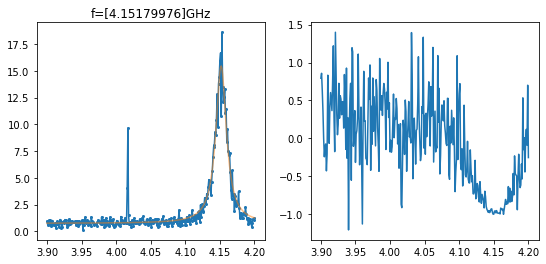

In [147]:
# tag, freq = q_target.q_name, np.arange(-200,201,1)*1e6+round(f_com,3)*1e9
freq = np.arange(3.9,4.2,0.001)*1e9
await psg_trans.setValue('Power',20)
# await measure.attinst['com9'].set_att(30)
# await cw.modulation_ex(q_target,measure)
await mrw.jpa_switch(measure,'ON')
job = Job(mrw.singlespec, (q_target,measure,freq,True,measure.f_lo,True), tags=(measure.qubitToread), max=len(freq))
f_ss, s_ss = await job.done()
state = await cww.QueryInst(measure)
index = np.abs(s_ss).argmax(axis=0)
x,y,z,band= f_ss/1e9, s_ss,[],[]
for i in range(np.shape(s_ss)[1]):
    try:
        a,b,c,d,e = op.Lorentz_Fit().fitLorentz(x[:,i],np.abs(y[:,i]))
        z.append(a/(1.0+c*(x[:,i]-b)**2)+d)
        band.append((b,e))
    except:
        pass
z = np.array(z).T
f_rabi = np.array([x[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=2)
axes[0].plot(x,z,alpha=0.5)
axes[0].set_title(f'f={np.array(band)[:,0]}GHz')
print(band)
axes[1].plot(x,np.angle(y))
plt.show()

In [241]:
f_rabi

array([4.419])

In [13]:
for i in range(10):
    globals()[f'q{i+1}'].replace(f_ex=f_rabi[i]*1e9,state=[state,measure.delta,measure.base,measure.readlen])

In [148]:
(4.152-4.017)*2

0.2699999999999996

In [166]:
q9.f_ex

4953500000.0

In [175]:
q9.replace(f_ex=5.2246e9)
q10.replace(f_ex=5.3902e9)

In [149]:
# q2.replace(f_ex=4.811e9,alpha=260e6,state=[state,measure.delta,measure.base,measure.readlen])
q4.replace(f_ex=4.1518e9,alpha=270e6,state=[state,measure.delta,measure.base,measure.readlen])
# q1.replace(f_ex=4.527e9,alpha=208e6,state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

,q8,q6,q3,q5,q4,q9,q2,q7,jpa,q10,...,psg_lo,psg_ex1,psg_trans,psg_pump,awg131,awg132,awg133,awg134,awgread,awg_trig
ch1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ON,ON,ON,OFF,ON,ON
ch2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
ch3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
ch4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
ch5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ON,ON,ON,OFF,ON,ON
ch6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
ch7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
ch8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,...,0,0,0,0,-220,-220,0,0,0,0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.657300GHz,4.610998GHz,4.200000GHz,13.482000GHz,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
q1.replace(f_ex=5.307e9,alpha=212e6,state=[state,measure.delta,measure.base,measure.readlen])
q2.replace(f_ex=4.981e9,state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

,q8,q6,q3,q5,q4,q9,q2,q7,jpa,q10,q1,psg_lo,psg_ex1,psg_trans,psg_pump,awg131,awg132,awg133,awg134,awgread
ch1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OFF,OFF,ON,OFF,ON
ch2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF
ch3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF
ch4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF
ch5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OFF,OFF,ON,OFF,ON
ch6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF
ch7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF
ch8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OFF,OFF,OFF,OFF,OFF
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,0,0,0,0,0,-220,-220,0,-220
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.656900GHz,5.076000GHz,5.299000GHz,13.502000GHz,NaN,NaN,NaN,NaN,NaN


## 单条谱扫电压

Output()

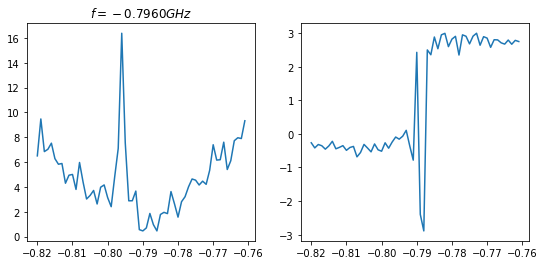

In [41]:
tag, ftarget, biaslist = 'q10', 4.4612e9, np.arange(-0.03,0.03,0.001) + (-0.79)

# await psg_trans.setValue('Power',13)
# mr.Att_Setup(measure,'com8').Att(28)
# await cw.modulation_ex(q_target,measure)
# # await psg_ex1.setValue('Moutput','OFF')
# await mr.jpa_switch(measure,'ON')
job = Job(mrw.specbias, (q10,measure,ftarget,biaslist,True), tags=[tag], max=len(biaslist))
v_sb, s_sb = await job.done()
index = np.abs(s_sb).argmax(axis=0)
v_rabi = np.array([v_sb[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(v_sb,np.abs(s_sb))
axes[0].set_title('$f=%.4fGHz$'%(v_rabi[0]))
axes[1].plot(v_sb,np.angle(s_sb))
plt.show()

# 功率拉比

In [142]:
q1.replace(envelopename=['hanning',1],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=300e6,pi_len=20e-9,\
         seqtype='PDD',detune=3e6)

In [84]:
q2.timing['read>xy'] = 3400e-9

Output()

(9.27048994640673, 7.497972357039413, 18056.26285332503, 0.9803921568627451, 0)


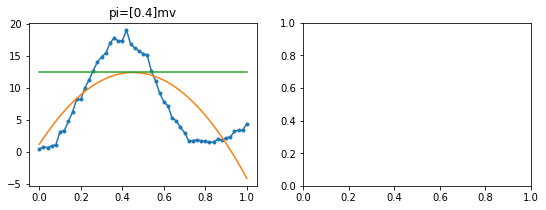

In [64]:
q_target = ['q1']
amp = np.linspace(0,1,51)
await awg100.write('TRIG:SOUR %s'%'INT') 
arg = 'pi_len' if np.max(amp)>1 else 'amp'
job = Job(mrw.rabi, (measure,amp,arg,q_target), tags=q_target, max=len(amp))
v_rp, s_rp = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
t_op = []
for i in range(np.shape(s_rp)[1]):
    x, y = v_rp[:,i], np.abs(s_rp[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    A,B,T1,w,phi,out = op.Rabi_Fit(envelopemethod='hilbert',phi=0).fitRabi(np.abs(x),np.abs(y))
    z = A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B
    env = A*np.exp(-x/T1) + B
    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].plot(x,z)
    axes[0].plot(x,env)
    axes[0].set_title(f'pi={t_op}mv')
plt.show()

In [63]:
q2.amp = 0.3

## Rabi_seq

In [473]:
q3.replace(envelopename=['hanning',1],nwave=1,amp=1,amp2=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=300e6,pi_len=20e-9,\
         pi_len2=20e-9,seqtype='PDD',detune=3e6,DRAGScaling=None,timing={'z>xy':0e-9,'read>xy':0e-9})

In [134]:
q10.timing['read>xy'] = 0e-9

In [160]:
q4.replace(envelopename=['gaussian',2],nwave=1,amp=1,amp2=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=300e6,pi_len=8e-9,\
         pi_len2=20e-9,seqtype='PDD',detune=3e6,DRAGScaling=None)

Output()

(14.46142420546944, 14.957427284636298, 20000, 0.9900990099009901, 0)
[0.42] [0.4989267917532939]


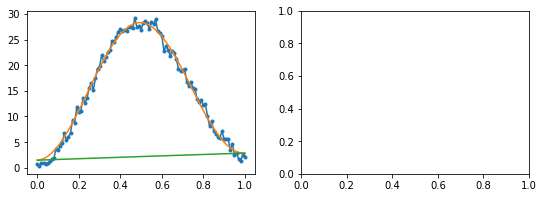

In [161]:
q_target = ['q4']
amp = np.linspace(0,1,101)
arg = 'amp'
comwave, readseq, mode = True, True, 'vbroadcast' 
numrepeat, avg, measure.repeat = (len(amp),False,1000) if mode == 'hbroadcast' else (300,True,len(amp))
job = Job(mrw.rabi_seq, (measure,amp,arg,q_target,comwave,readseq,mode), tags=q_target, max=numrepeat,avg=avg)
v_rp, s_rp = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
t_op, t_fit = [], []
for i in range(np.shape(s_rp)[1]):
    x, y = v_rp[:,i], np.abs(s_rp[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    A,B,T1,w,phi,out = op.Rabi_Fit(envelopemethod='hilbert',phi=0).fitRabi(np.abs(x),np.abs(y))
    t_fit.append(1/w/2)
    z = A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B
    env = A*np.exp(-x/T1) + B
    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].plot(x,z)
    axes[0].plot(x,env)
#     axes[0].set_title(f't_op={t_op}mv,pi={t_fit}mv')
print(t_op,t_fit)
plt.show()

In [162]:
# q9.amp = 0.3054
q8.amp = 0.66
q7.amp = 0.8
q9.amp = 0.5889
q10.amp = 0.18
q4.amp = 0.42

## 2态拉比

In [70]:
q2.replace(envelopename=['hanning',2],nwave=1,amp=1,amp2=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=-100e6,pi_len=10e-9,\
         pi_len2=20e-9,seqtype='PDD',detune=3e6,DRAGScaling=None,timing={'z>xy':0e-9,'read>xy':0e-9})

Output()

(6.9120570605464255, 23.81015258358814, 20000, 5.9405940594059405, 0)
[0.09] [0.1022155702565451]


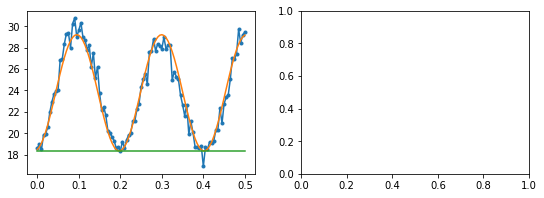

In [72]:
q_target = ['q2']
amp = np.linspace(0,0.5,101)
arg = 'amp'
comwave, readseq, mode = True, True, 'vbroadcast'

numrepeat, avg, measure.repeat = (len(amp),False,500) if mode == 'hbroadcast' else (300,True,500)
job = Job(mrw.rabi2_seq, (measure,amp,arg,q_target,comwave,readseq,mode), tags=q_target, max=numrepeat,avg=avg)
v_rp, s_rp = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
t_op, t_fit = [], []
for i in range(np.shape(s_rp)[1]):
    x, y = v_rp[:,i], np.abs(s_rp[:,i])
    t_op.append(op.RowToRipe().firstMax(x,y,num=0,peakpercent=0.8))
    A,B,T1,w,phi,out = op.Rabi_Fit(envelopemethod='hilbert',phi=0).fitRabi(np.abs(x),np.abs(y))
    t_fit.append(1/w/2)
    z = A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B
    env = A*np.exp(-x/T1) + B
    axes[0].plot(x,y,'-o',markersize=3)
    axes[0].plot(x,z)
    axes[0].plot(x,env)
#     axes[0].set_title(f't_op={t_op}mv,pi={t_fit}mv')
print(t_op,t_fit)
plt.show()

In [73]:
q2.amp2 = 0.10222

# IQ-Mixer 线性度

In [323]:
q_target = q10
amp = np.linspace(0.1,1,10)
t_rabi = np.linspace(1,201,101)
job = Job(mrw.lineIQMixer, (measure,amp,t_rabi,[q_target.q_name],'vbroadcast'), tags=[tag], max=len(amp))
v_pi, t_pi, s_pi = await job.done()

Output()

# 优化Pi脉冲

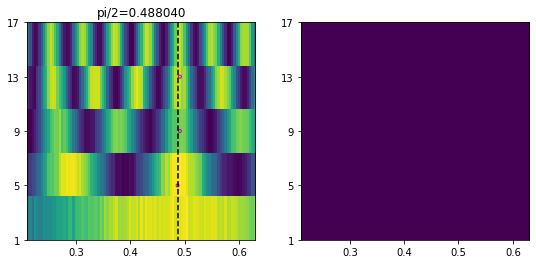

In [168]:
# q_target, nwave, wavlen = q4, 5, 101
# tag = q_target.q_name
# optwhich = 'amp'
# job = Job(mrw.pipulseOpt, (measure,nwave,wavlen,optwhich,[q_target.q_name],'vbroadcast'), tags=[tag], max=nwave)
# n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=0.48,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

In [159]:
q4.inst

{'z_awg': 'awg132',
 'z_ch': [6],
 'ex_awg': 'awg133',
 'ex_ch': [4, 8],
 'ex_lo': 'psg_ex1',
 'com': 'com3'}

In [169]:
q10.amp = 0.456768
q9.amp = 0.558282
q8.amp = 0.77484
q2.amp = 0.37262
q1.amp = 0.38766
q3.amp = 0.645
q7.amp = 0.8572
q4.amp = 0.48804

# AllXY dragdetune

Output()

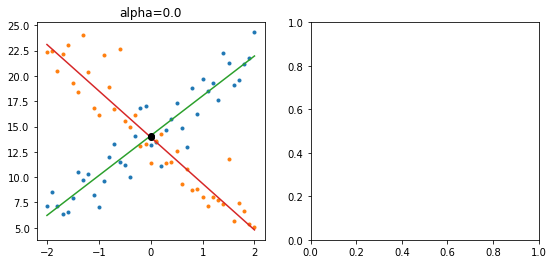

In [170]:
q_target = q4
which = 0
#alpha = q_target.alpha
#await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.AllXYdragdetune, (measure,which,[q_target.q_name]), tags=[q_target.q_name], max=82)
fall, sall = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
l = np.shape(fall)[0]//2
f1, f2, s1, s2 = fall[:l,0], fall[l:,0], np.abs(sall[:l,0]), np.abs(sall[l:,0])
z1 = np.poly1d(np.polyfit(f1,s1,1))(f1)
z2 = np.poly1d(np.polyfit(f2,s2,1))(f2)
index = np.argmin(np.abs(z1-z2))
axes[0].plot(np.array([f1,f2]).T,np.array([s1,s2]).T,'.')
axes[0].plot(np.array([f1,f2]).T,np.array([z1,z2]).T)
# axes[0].plot(fall[l:,:],np.abs(sall[l:,:]))
axes[0].plot([f1[index],f2[index]],[z1[index],z2[index]],'ko')
axes[0].set_title(f'alpha={round(f1[index],3)}')
plt.show()

In [171]:
q9.DRAGScaling = -0/(q9.alpha*2*np.pi)
q2.DRAGScaling = -0.4/(q2.alpha*2*np.pi)
q1.DRAGScaling = 0.1/(q1.alpha*2*np.pi)
q3.DRAGScaling = -0.6/(q3.alpha*2*np.pi)
q8.DRAGScaling = 0.5/(q8.alpha*2*np.pi)
q7.DRAGScaling = -0.3/(q7.alpha*2*np.pi)
q4.DRAGScaling = 0/(q4.alpha*2*np.pi)

# AC_Stark

In [53]:
#波形尾部在 87 us处， 波形宽度为 50 ns
q1.replace(envelopename=['hanning',2],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=5.6e-9,\
         seqtype='PDD',detune=3e6)

In [199]:
q1.timing["read>xy"]=10e-9

## 单条

In [172]:
q4.timing = {'read>xy':0,'z>xy':0}

In [ ]:
q_target = q4
t_rabi = np.linspace(2800,3100,201)
power = 0.1
tag = q_target.q_name
job = Job(mrw.singleacStark, (measure,t_rabi,power,[q_target.q_name]), tags=[tag], no_bar=True)
t_shift, s_ac = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
for i in range(np.shape(s_ac)[1]):
    x, y = t_shift[:,i], np.abs(s_ac[:,i])
    axes[0].plot(x,y,'-o',markersize=3)
plt.show()

Output()

In [184]:
2988-3050

-62

In [42]:
q1.timing['read>xy'] = 0e-9 + 150e-9
q2.timing['read>xy'] = 0e-9 + 150e-9
q3.timing['read>xy'] = 0e-9 + 150e-9
q4.timing['read>xy'] = 0e-9 + 150e-9
q5.timing['read>xy'] = 0e-9 + 150e-9
q6.timing['read>xy'] = 0e-9 + 150e-9
q7.timing['read>xy'] = -50e-9 + 150e-9
q8.timing['read>xy'] = -62e-9 + 150e-9
q9.timing['read>xy'] = -84e-9 + 300e-9
q10.timing['read>xy'] = -67e-9 + 300e-9

## 二维

In [210]:
q1.f_ex = 4.643e9

In [129]:
q_target = q2
t_rabi = np.linspace(2000,5000,201)
power = 0.2
tag = q_target.q_name
job = Job(mrw.acStark, (measure,t_rabi,power,[q_target.q_name]), tags=[tag],max=51)
freq, t_shift, s_ac = await job.done()

Output()

TypeError: cannot unpack non-iterable NoneType object

# 腔内光子数

In [30]:
q2.f_ex = 4811430000.0

In [171]:
q_target = q2
power = np.linspace(0,0.1,101)
end = 3000
tag = q_target.q_name
job = Job(mrw.photonNum, (measure,power,end,[q_target.q_name]), tags=[tag],max=51)
freq, t_shift, s_ac = await job.done()

Output()

# Z脉冲

## 单条

In [35]:
#波形尾部在 87 us处， 波形宽度为 50ns, 最低点应为3025
q1.replace(pi_len=10.8e-9)

In [92]:
q2.f_ex

4603500000.0

In [39]:
q9.timing['z>xy'] = 0

Output()

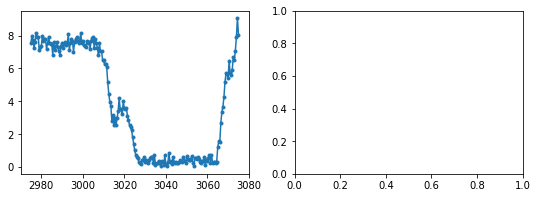

In [44]:
q_target = q7
t_rabi = np.linspace(2975,3075,201)
att_single = 30
tag = q_target.q_name
job = Job(mrw.singleZpulse, (measure,t_rabi,[q_target.q_name]), tags=[tag],no_bar=True)
t_shift, s_z = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
for i in range(np.shape(s_z)[1]):
    x, y = t_shift[:,i], np.abs(s_z[:,i])
    axes[0].plot(x,y,'-o',markersize=3)
plt.show()

In [45]:
3046-3025

21

In [46]:
q1.timing['z>xy'] = 0e-9 + 50e-9
q2.timing['z>xy'] = 0e-9 + 50e-9
q3.timing['z>xy'] = 0e-9 + 50e-9
q4.timing['z>xy'] = 0e-9 + 50e-9
q5.timing['z>xy'] = 0e-9 + 50e-9
q6.timing['z>xy'] = 0e-9 + 50e-9
q7.timing['z>xy'] = 21e-9 
q8.timing['z>xy'] = -25e-9 
q9.timing['z>xy'] = -22e-9 
q10.timing['z>xy'] = -30e-9 + 150e-9

## 二维

In [97]:
q_target = q2
t_rabi = np.linspace(2895,2985,201)
att_single = 30
tag = q_target.q_name
# await psg[q_target.inst['ex_lo']].setValuez('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.zPulse, (measure,t_rabi,[q_target.q_name]), tags=[tag],max=40)
freq, t_shift, s_z = await job.done()

Output()

## 二维Population

In [131]:
q_target = q7
t_rabi = np.append(np.append(np.append(np.arange(3800,4900,50),np.arange(4900,4950,5)),np.arange(4950,5050,1)),np.arange(5050,5200,5))
which = measure.onwhich
tag = q_target.q_name
await cww.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=1000,weight=weight)
job = Job(mrw.zPulse_pop, (measure,t_rabi,which,[q_target.q_name]), tags=[tag],max=len(t_rabi))
freq, t_shift, s_z = await job.done()

Output()

In [119]:
np.array(np.mat(measure.readmatrix['q7']).I*np.mat([1,0.5]).T)

array([[0.99138293],
       [0.50861707]])

In [125]:
np.array([[1,2],[3,4]])[:,1]

array([2, 4])

In [201]:
bits = [q8,q9]
for i in bits:
    q_target = i
    await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])
    task = await mrw.executeZwave(measure,cww.zWave,dcstate={},output=True,during=0/1e9,shift=3000e-9)
    task_ex = await mrw.executeEXwave(measure,cww.rabiWave,exstate=[q_target.q_name],output=True)
    mrw.concurrence([{**task[0],**task_ex[0]},{**task[1],**task_ex[1]}])
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await cww.RecoverInst(measure,state=q_target.state[0])
    measure.qubitToread = [q_target.q_name]
    measure.readamp = q_target.readamp
    measure.ringup = q_target.ringup
    measure.ringupamp = q_target.ringupamp
    pulse = await cww.modulation_read(measure,measure.delta,readlen=1200,weight=q_target.weight)

    t_rabi = np.append(np.append(np.append(np.arange(1800,4800,50),np.arange(4800,4950,5)),np.arange(4950,5050,1)),np.arange(5050,5200,5))
    which = measure.onwhich
    tag = q_target.q_name
    await cww.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=1000,weight=weight)
    job = Job(mrw.zPulse_pop, (measure,t_rabi,which,[q_target.q_name]), tags=[tag],max=len(t_rabi))
    freq, t_shift, s_z = await job.done()

Output()

QuLabRPCServerError: ('ValueError', 'operands could not be broadcast together with shapes (1536,) (1088,) ', 'd:\\qulab\\qulab\\rpc.py in handle_request(self, source, msgID, method)\n  279     async def handle_request(self, source, msgID, method, *args, **kw):\n  280         """\n  281         Handle a request from source.\n  282         """\n  283         try:\n  284             func = self.getRequestHandler(method, source=source, msgID=msgID)\n  285             if \'timeout\' in kw and not acceptArg(func, \'timeout\'):\n  286                 del kw[\'timeout\']\n  287             if inspect.iscoroutinefunction(func):\n  288                 result = await func(*args, **kw)\n  289             else:\n  290                 result = await self.loop.run_in_executor(\n->291                     self.executor, functools.partial(func, *args, **kw))\n  292             if isinstance(result, Awaitable):\n  293                 result = await result\n  294         except QuLabRPCError as e:\n  295             result = e\n  296         except Exception as e:\n  297             result = QuLabRPCServerError.make(e)\n  298         msg = pack(result)\n  299         await self.response(source, msgID, msg)\n  300 \nC:\\WPy64-3740\\python-3.7.4.amd64\\lib\\asyncio\\futures.py in __await__(self)\n  257     def __await__(self):\n  258         if not self.done():\n  259             self._asyncio_future_blocking = True\n->260             yield self  # This tells Task to wait for completion.\n  261         if not self.done():\n  262             raise RuntimeError("await wasn\'t used with future")\n  263         return self.result()  # May raise too.\n  264 \nC:\\WPy64-3740\\python-3.7.4.amd64\\lib\\asyncio\\tasks.py in __wakeup(self, future)\n  316     def __wakeup(self, future):\n  317         try:\n->318             future.result()\n  319         except Exception as exc:\n  320             # This may also be a cancellation.\n  321             self.__step(exc)\n  322         else:\n  323             # Don\'t pass the value of `future.result()` explicitly,\n  324             # as `Future.__iter__` and `Future.__await__` don\'t need it.\n  325             # If we call `_step(value, None)` instead of `_step()`,\n  326             # Python eval loop would use `.send(value)` method call,\n  327             # instead of `__next__()`, which is slower for futures\n  328             # that return non-generator iterators from their `__iter__`.\n  329             self.__step()\n  330         self = None  # Needed to break cycles when an exception occurs.\n  331 \nC:\\WPy64-3740\\python-3.7.4.amd64\\lib\\asyncio\\futures.py in result(self)\n  165     def result(self):\n  166         """Return the result this future represents.\n  167 \n  168         If the future has been cancelled, raises CancelledError.  If the\n  169         future\'s result isn\'t yet available, raises InvalidStateError.  If\n  170         the future is done and has an exception set, this exception is raised.\n  171         """\n  172         if self._state == _CANCELLED:\n  173             raise CancelledError\n  174         if self._state != _FINISHED:\n  175             raise InvalidStateError(\'Result is not ready.\')\n  176         self.__log_traceback = False\n  177         if self._exception is not None:\n->178             raise self._exception\n  179         return self._result\n  180 \nC:\\WPy64-3740\\python-3.7.4.amd64\\lib\\concurrent\\futures\\thread.py in run(self)\n   52     def run(self):\n   53         if not self.future.set_running_or_notify_cancel():\n   54             return\n   55 \n   56         try:\n-> 57             result = self.fn(*self.args, **self.kwargs)\n   58         except BaseException as exc:\n   59             self.future.set_exception(exc)\n   60             # Break a reference cycle with the exception \'exc\'\n   61             self = None\n   62         else:\n   63             self.future.set_result(result)\n   64 \nd:\\qulab\\qulab\\drivers\\AlazarTechDigitizer\\Driver.py in set(self)\n   68     def set(self, **cmd):\n   69         if \'n\' in cmd:\n   70             cmd[\'samplesPerRecord\'] = getSamplesPerRecode(cmd[\'n\'])\n   71             cmd[\'n\'] = getSamplesPerRecode(cmd[\'n\'])\n   72         self.config.update(cmd)\n   73 \n   74         if self.config[\'repeats\'] % self.config[\'recordsPerBuffer\'] != 0:\n   75             self.config[\'repeats\'] = (\n   76                 self.config[\'repeats\'] // self.config[\'recordsPerBuffer\'] +\n   77                 1) * self.config[\'recordsPerBuffer\']\n   78 \n   79         if any(key in [\'f_list\', \'n\', \'weight\', \'sampleRate\'] for key in cmd):\n   80             self.config[\'e\'] = getExpArray(self.config[\'f_list\'],\n   81                                            self.config[\'n\'],\n   82                                            self.config[\'weight\'],\n-> 83                                            self.config[\'sampleRate\'])\n   84 \n   85         if any(key in [\n   86                 \'ARange\', \'BRange\', \'trigLevel\', \'triggerDelay\',\n   87                 \'triggerTimeout\'\n   88         ] for key in cmd):\n   89             configure(self.dig, **self.config)\n   90 \nd:\\qulab\\qulab\\drivers\\AlazarTechDigitizer\\Driver.py in getExpArray(f_list, numOfPoints, weight, sampleRate)\n   30 def getExpArray(f_list, numOfPoints, weight=None, sampleRate=1e9):\n   31     #numOfPoints时域信号的点数\n   32     e = []\n   33     t = np.arange(0, numOfPoints, 1) / sampleRate\n   34     if weight is None:\n   35         weight = np.ones(numOfPoints)\n   36     for f in f_list:\n-> 37         e.append(weight * np.exp(-1j * 2 * np.pi * f * t))\n   38     return np.asarray(e).T\n   39 ')

In [209]:
q2.asdict()

{'q_name': 'q2',
 'inst': {'z_awg': 'awg132',
  'z_ch': [2],
  'ex_awg': 'awg131',
  'ex_ch': [2, 6],
  'ex_lo': 'psg_ex1',
  'com': 'com3'},
 'T_bias': [2.692, 0.164],
 'T_z': [1.663, 0.108],
 'specfunc': 0.206343969938231*(0.0771313758211651*tan(1.15120887554679*x - 0.1795885845853)**2 + 1)**(1/4)*sqrt(Abs(cos(1.15120887554679*x - 0.1795885845853))) - 0.921039636712871,
 'specfunc_cavity': sqrt((0.206343969938231*(0.0771313758211651*tan(1.15120887554679*x - 0.1795885845853)**2 + 1)**(1/4)*sqrt(Abs(cos(1.15120887554679*x - 0.1795885845853))) - 7.3364689520535)**2 + 4.30472701619145)/2 + 0.103171984969116*(0.0771313758211651*tan(1.15120887554679*x - 0.1795885845853)**2 + 1)**(1/4)*sqrt(Abs(cos(1.15120887554679*x - 0.1795885845853))) + 2.74719483931388,
 'photonnum_func': None,
 'bias': 0.65,
 'zpulse': None,
 'f_lo': array([6.466e+09]),
 'delta': array([50000000.]),
 'f_ex': 4812997029.7029705,
 'delta_ex': 300000000.0,
 'alpha': 260000000.0,
 'power_ex': 30,
 'power_rabi': 13,
 'pi_le

In [193]:
measure.qubits["q2"].asdict()

{'q_name': 'q2',
 'inst': {'z_awg': 'awg132',
  'z_ch': [2],
  'ex_awg': 'awg131',
  'ex_ch': [2, 6],
  'ex_lo': 'psg_ex1',
  'com': 'com3'},
 'T_bias': [2.692, 0.164],
 'T_z': [1.663, 0.108],
 'specfunc': 0.206343969938231*(0.0771313758211651*tan(1.15120887554679*x - 0.1795885845853)**2 + 1)**(1/4)*sqrt(Abs(cos(1.15120887554679*x - 0.1795885845853))) - 0.921039636712871,
 'specfunc_cavity': sqrt((0.206343969938231*(0.0771313758211651*tan(1.15120887554679*x - 0.1795885845853)**2 + 1)**(1/4)*sqrt(Abs(cos(1.15120887554679*x - 0.1795885845853))) - 7.3364689520535)**2 + 4.30472701619145)/2 + 0.103171984969116*(0.0771313758211651*tan(1.15120887554679*x - 0.1795885845853)**2 + 1)**(1/4)*sqrt(Abs(cos(1.15120887554679*x - 0.1795885845853))) + 2.74719483931388,
 'photonnum_func': None,
 'bias': 0.65,
 'zpulse': None,
 'f_lo': array([6.466e+09]),
 'delta': array([50000000.]),
 'f_ex': 4812997029.7029705,
 'delta_ex': 300000000.0,
 'alpha': 260000000.0,
 'power_ex': 30,
 'power_rabi': 13,
 'pi_le

In [195]:
measure.onwhich

{'q1': 1, 'q2': 0}

# T1

In [55]:
q6.pi_len = 16e-9

Output()

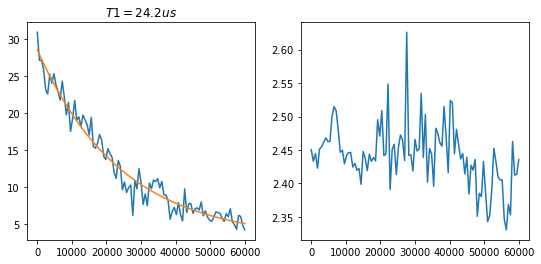

In [56]:
t_T1, q_target = np.linspace(0,60000,101,endpoint=True), ['q6']
job = Job(mrw.rabi, (measure,t_T1,'shift',q_target), tags=q_target, max=len(t_T1))
t_t, s_t = await job.done()
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]*T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1fus$'%(1/T1/1000))
axes[1].plot(t_t,np.angle(s_t))
plt.show()

# T1_seq

In [139]:
q1.replace(pi_len=10.6e-9)

In [114]:
q10.timing['read>xy'] = 100e-9

Output()

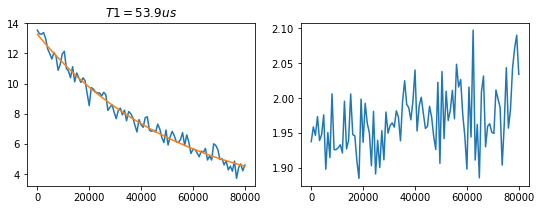

In [67]:
q_target = ['q7']
amp = np.linspace(0,80000,101)
arg = 'shift'
comwave, readseq, mode = True, True, 'vbroadcast'

numrepeat, avg, measure.repeat = (len(amp),False,500) if mode == 'hbroadcast' else (300,True,len(amp))
job = Job(mrw.rabi_seq, (measure,amp,arg,q_target,comwave,readseq,mode), tags=q_target, max=numrepeat,avg=avg)
t_t, s_t = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]*T1) + B
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1fus$'%(1/T1/1000))
axes[1].plot(t_t,np.angle(s_t))
plt.show()

# Ramsey

In [69]:
q1.replace(nwave=0,seqtype='PDD',detune=2e6)

Output()

(27.678096420331716, -69.25510484251407, 30000, 26397.890093965696, 0.0015841584158415843, 0)


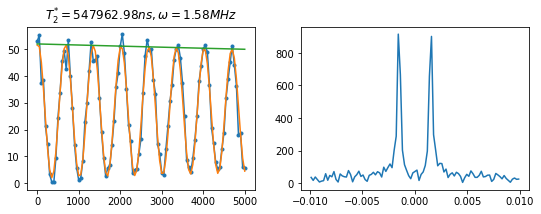

In [112]:
t_Ramsey, q_target = np.linspace(0,5000,101), ['q2']
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))

job = Job(mrw.Ramsey, (measure,t_Ramsey,q_target), tags=q_target, max=len(t_Ramsey))
t_ram, s_ram = await job.done()
x, y = t_ram[:,0], (s_ram[:,0])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=30000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
axes[0].plot(t_ram,np.abs(s_ram),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}^{*}=%.2fns,\omega=%.2fMHz$'%(T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [194]:
f = await  psg_ex1.getValue('Frequency')
await psg_ex1.setValue('Frequency',(f-w*1e9+2e6))
print(f)

4943000000.0


In [195]:
q1.f_ex = f - q1.delta_ex

In [113]:
q1.asdict()

{'q_name': 'q1',
 'inst': {'z_awg': 'awg132',
  'z_ch': [1],
  'ex_awg': 'awg134',
  'ex_ch': [4, 8],
  'ex_lo': 'psg_ex1',
  'com': 'com3'},
 'T_bias': [3.319, -0.284],
 'T_z': [2.101, -0.194],
 'specfunc': 5.25149015598707*(0.942356245310643*tan(0.934656305237647*x + 0.218709575425609)**2 + 1)**(1/4)*sqrt(Abs(cos(0.934656305237647*x + 0.218709575425609))) - 0.81966338969257,
 'specfunc_cavity': sqrt((5.25149015598707*(0.942356245310643*tan(0.934656305237647*x + 0.218709575425609)**2 + 1)**(1/4)*sqrt(Abs(cos(0.934656305237647*x + 0.218709575425609))) - 7.33303642022885)**2 + 0.268557160758026)/2 + 2.62574507799353*(0.942356245310643*tan(0.934656305237647*x + 0.218709575425609)**2 + 1)**(1/4)*sqrt(Abs(cos(0.934656305237647*x + 0.218709575425609))) + 2.84685482042185,
 'photonnum_func': None,
 'bias': 0,
 'zpulse': None,
 'f_lo': array([6.535e+09]),
 'delta': array([50000000.]),
 'f_ex': 5308400000.0,
 'delta_ex': 300000000.0,
 'alpha': 212000000.0,
 'power_ex': 60,
 'power_rabi': 30,
 

# ramsey_seq

In [163]:
q4.replace(nwave=0,seqtype='PDD',detune=2e6)
# await cww.clearSeq(measure,['awg133','awg134'])

Output()

(13.022428465444065, 15.639823121316132, 30000, 1564.4664266319523, 0.0019801980198019802, 0)


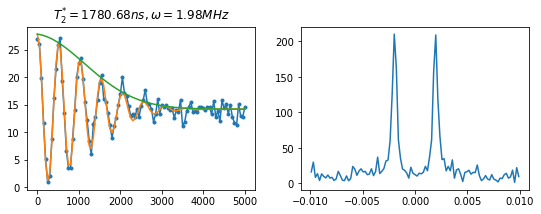

In [164]:
q_target = ['q4']
t_Ramsey = np.linspace(0,5000,101)
att_single = 30
comwave, readseq, mode = True, True, 'vbroadcast'

numrepeat, avg = (len(t_Ramsey),False) if mode == 'hbroadcast' else (300,True)
job = Job(mrw.Ramsey_seq, (measure,t_Ramsey,q_target,comwave,readseq,mode), tags=q_target, max=numrepeat,avg=avg)
t_ram, s_ram = await job.done()
x, y = t_ram[:,0], (s_ram[:,0])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=30000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
axes[0].plot(t_ram,np.abs(s_ram),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}^{*}=%.2fns,\omega=%.2fMHz$'%(T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [165]:
f = await  psg['psg_ex1'].getValue('Frequency')
await psg['psg_ex1'].setValue('Frequency',(f-w*1e9+2e6))
print(f)

4451800000.0


In [158]:
q2.f_ex

4811430000.0

In [166]:
q4.f_ex = f-w*1e6+2e6 - q4.delta_ex

# SpinEcho

In [47]:
q6.replace(nwave=1,seqtype='CPMG',detune=1e6)

In [36]:
t_spin, q_target = np.linspace(0,15000,101), ['q6']

job = Job(mrw.SpinEcho, (measure,t_spin,q_target), tags=q_target, max=len(t_spin))
t_sp, s_sp = await job.done()
x, y = t_sp[:,0], s_sp[:,0]
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=100000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}=%.2fus,w=%fMHz$'%(np.abs(T2/1000),w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

Output()

TypeError: cannot unpack non-iterable NoneType object

# SpinEcho_seq

In [73]:
q10.replace(nwave=1,seqtype='CPMG',detune=1e6)

Output()

(9.157542566974767, 8.543204781254092, 50000, 9467.04738466723, 0.0009950248756218905, 0)


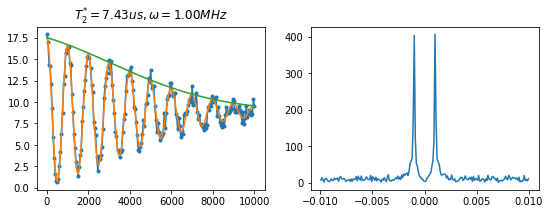

In [74]:
t_spin, q_target = np.linspace(0,10000,201), ['q10']
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))

job = Job(mrw.SpinEcho_seq, (measure,t_spin,q_target,True), tags=q_target, max=500, avg=True)
t_sp, s_sp = await job.done()
x, y = t_sp[:,0], (s_sp[:,0])
A,B,T1,T2,w,phi,out = op.T2_Fit(T1=50000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
w,yt,amp = op.RowToRipe().fourier(x,y)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,3))
axes[0].plot(x,np.abs(y),'-o',markersize=3)
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{2}^{*}=%.2fus,\omega=%.2fMHz$'%(T2/1e3,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [111]:
np.shape(t_sp)

(201, 1)

# Spec2d_awg

In [183]:
q1.replace(envelopename=['square',1],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=120e6,pi_len=23e-9,\
         seqtype='CPMG',detune=3e6)

In [121]:
freq = np.arange(3.7,4.7,0.001)*1e9
bits = [q1]
await psg_trans.setValue('Power',0)
# await measure.attinst['com8'].set_att(20)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(25)
    await mrw.jpa_switch(measure,'ON')
    print(i.q_name)
    job = Job(mrw.spec2d_awg, (i,measure,freq,None), tags=[i.q_name], max=61)
    v_s2, f_s2, s_s2 = await job.done()

q1


Output()

TypeError: cannot unpack non-iterable NoneType object

# OPTweight

In [60]:
q_target = ['q7']
job = Job(mrw.readOpweight, (measure,q_target), tags=q_target, max=2)
ampop= await job.done()
amp_off, amp_on = ampop[0][0,:], ampop[0][1,:]
ampdiff = np.abs(amp_on-amp_off)
weight = ampdiff/np.mean(ampdiff)
measure.qubits[q_target[0]].weight = weight
plt.figure()
# plt.plot(np.abs(amp_off))
# plt.plot(np.abs(amp_on))
# plt.plot(ampdiff)
plt.plot(weight)

Output()

# 优化读出点

In [331]:
q10.timing

{'z>xy': -1e-08, 'read>xy': 3.044e-06}

Output()

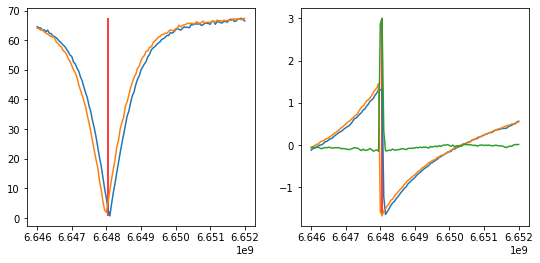

In [48]:
q_target = ['q7']
# await measure.attinst['com8'].set_att(30)
# await measure.attinst[q_target.inst['com']].set_att(q_target.power_rabi)
await mrw.jpa_switch(measure,state='ON')
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
job = Job(mrw.readOp, (measure,q_target), tags=q_target, max=2)
st, f_op, s_op= await job.done()
f_lo = []
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(measure.n):
    f, s_off, s_on = f_op[:,:,i][0], s_op[:,:,i][0], s_op[:,:,i][1]
    f_lo1 = (f[np.argmin(np.abs(s_off))] + f[np.argmin(np.abs(s_on))])/2
    x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
    x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
    anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
    index = np.abs(anglediff).argmax(axis=0)
    #index = np.abs(s_off).argmin(axis=0)
    f_lo.append(f[index] if np.abs(f[index]-f_lo1)<0.1e6 else f_lo1)
    axes[0].plot(f_op[:,:,i].T,np.abs(s_op[:,:,i].T))
    axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,i].T)),np.min(np.abs(s_op[:,:,i].T)),'r')
    axes[1].plot(x_off,np.angle(y_off[0]))
    axes[1].plot(x_on,np.angle(y_on[0]))
    axes[1].plot(x_off,anglediff)
    axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()
f_lo, delta, n = await mrw.resn(np.array(f_lo))
measure.f_lo, measure.delta, measure.n = f_lo, delta, n
axes[0].set_title(f'fread={f_lo-measure.delta}')
await psg['psg_lo'].setValue('Frequency',f_lo)

In [75]:
f_lo-50e6

6729450000.0

In [180]:
freqall = np.array([6.545, 6.564, 6.588, 6.608, 6.63, 6.642, 6.649, 6.689, 6.70935, 6.72945])*1e9
# freqall = freqall[::-1]
f_cavity = {'q%d'%(i):j for i, j in enumerate(freqall,start=1)}
measure.freqall = f_cavity

In [210]:
await psg['psg_lo'].setValue('Frequency',6.729e9)

# 临界判断

In [81]:
measure.readamp = [0.05]
measure.ringup = [150]
measure.ringupamp = [0.16]
pulse = await cww.modulation_read(measure,measure.delta,readlen=1800,weight=weight)

In [199]:
q8.replace(readamp=measure.readamp,ringup=measure.ringup,ringupamp=measure.ringupamp)

In [187]:
q2 = measure.qubits['q2']

Output()

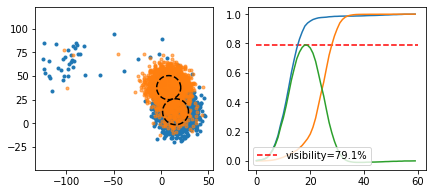

In [82]:
q_target = q7
# await measure.attinst['com8'].set_att(29)
await mrw.jpa_switch(measure,'ON')
job = Job(mrw.threshHold, (measure,[q_target.q_name]), tags=[q_target.q_name], max=3)
st, s_st, s_st_Q = await job.done()
num = measure.n
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on, s_on2 = s_st[0,:,i], s_st[1,:,i], s_st[2,:,i]
    data = await mrw.visibility(1,s_off,s_on)
    ax0 = axes[i][0] if num>1 else axes[i]
    ax0.plot(np.real(s_off),np.imag(s_off),'.')
    ax0.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax0.plot(np.real(s_on2),np.imag(s_on2),'.',alpha=0.6)
    ax0.plot(*(data[0][3]),'k--')
    ax0.plot(*(data[0][4]),'k--')
    ax0.axis('equal')
    ax1 = axes[i][1] if num>1 else axes[i+1]
    for j in data[0][:3]:
        ax1.plot(j)
    maxdata = np.max(data[0][2])
    ax1.hlines(maxdata,0,60,'r','--',label=f'visibility={round(maxdata*100,1)}%')
    ax1.legend(loc='lower left')
#     ax1.vlines([0],10,-100)
#     ax1.hlines([0],-10,100)

plt.show()

In [163]:
measure.qubits['q10'].asdict()

{'q_name': 'q10',
 'inst': {'z_awg': 'awg131',
  'z_ch': [5],
  'ex_awg': 'awg134',
  'ex_ch': [2, 6],
  'ex_lo': 'psg_ex1',
  'com': 'com3'},
 'T_bias': [2.966, 0.068],
 'T_z': [1.787, 0.056],
 'specinterp': [array([4.65515808, 4.65516678, 4.65517548, ..., 5.72418973, 5.72418994,
         5.72419015]),
  array([-5.000000e-01, -4.999980e-01, -4.999960e-01, ..., -4.000016e-06,
         -2.000008e-06,  0.000000e+00])],
 'specfunc': 2.27713053920308*(0.0916189233265407*tan(1.94793160841997*x - 0.0662296746862791)**2 + 1)**(1/4)*sqrt(Abs(cos(1.94793160841997*x - 0.0662296746862791))) - 0.710559094860302,
 'specfuncz': [5.85101989573697*(0.00469298661654138*tan(1.64089637974623*x - 0.0217646468575629)**2 + 1)**(1/4)*sqrt(Abs(cos(1.64089637974623*x - 0.0217646468575629))) - 0.126140079506901,
  0.013263876455702123,
  1.9145588303849175,
  33.92501609533709,
  0.12614007950690131,
  0.06850537655207352],
 'specfunc_cavity': sqrt((2.27713053920308*(0.0916189233265407*tan(1.94793160841997*x - 

In [458]:
q_target = q3
await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])
task = await mrw.executeZwave(measure,cww.zWave,dcstate={},output=True,pi_len=0/1e9,shift=3000e-9)
task_ex = await mrw.executeEXwave(measure,cww.rabiWave,exstate=[q_target.q_name],output=True)
mrw.concurrence([{**task[0],**task_ex[0]},{**task[1],**task_ex[1]}])
measure.delta,measure.base,measure.readlen = q_target.state[1:]
await cww.RecoverInst(measure,state=q_target.state[0])
measure.qubitToread = [q_target.q_name]
measure.readamp = q_target.readamp
measure.ringup = q_target.ringup
measure.ringupamp = q_target.ringupamp
pulse = await cww.modulation_read(measure,measure.delta,readlen=1200,weight=q_target.weight)

In [57]:
# pulselist = await cww.funcarg(cww.rabiWave,q9,shift=1000/1e9)
# await cww.writeWave(awg133,name=['ch2','ch6'],pulse=pulselist)
# await cww.couldRun(awg133)
pulse1 = await cww.funcarg(cww.zWave,q9,during=2000/1e9,volt=-0,shift=5000e-9)
# pulse2 = await cww.funcarg(cww.zWave,q2,pi_len=10000/1e9,volt=0,shift=1500e-9)
# pulse = pulse1 + pulse2
# pulse = np.array(pulse1) + np.array(pulse2)
await cww.writeWave(measure,awg131,['ch1'],pulse1)
await cww.couldRun(measure,awg131)

In [198]:
state = await cww.QueryInst(measure)
q8.replace(state=[state,measure.delta,measure.base,measure.readlen])
pd.DataFrame(state)

,q8,q6,q3,q5,q4,q9,q2,q7,jpa,q10,...,psg_lo,psg_ex1,psg_trans,psg_pump,awg131,awg132,awg133,awg134,awgread,awg_trig
ch1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ON,ON,ON,OFF,ON,ON
ch2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
ch3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,ON,OFF,ON,ON
ch4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
ch5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ON,ON,ON,OFF,ON,ON
ch6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
ch7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,ON,OFF,ON,ON
ch8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OFF,ON,OFF,OFF,OFF,OFF
error,+0,+0,+0,+0,+0,+0,+0,+0,+0,+0,...,0,0,0,0,-420,-420,0,0,0,0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.738250GHz,5.145997GHz,4.999000GHz,13.482000GHz,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
np.shape(s_off)

(3008,)

0.46060505319148937


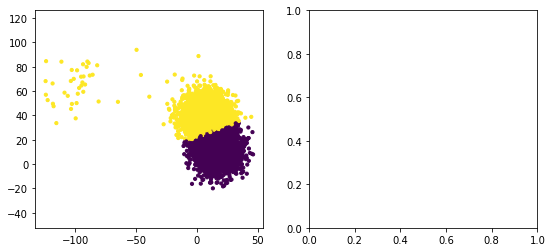

In [87]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(1):
    i = 0
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    S = list(s_off) + list(s_on)
    x,z = np.real(S), np.imag(S)
    d = list(zip(x,z))
    kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
    kmeans.fit(d)
    predict[measure.qubitToread[i]] = kmeans.predict
    y = kmeans.predict(d)
    print(list(y).count(1)/len(y))
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(x,z,c=y,s=10)
    ax.axis('equal')
plt.show()
measure.predict = predict

In [16]:
np.max(y)

2

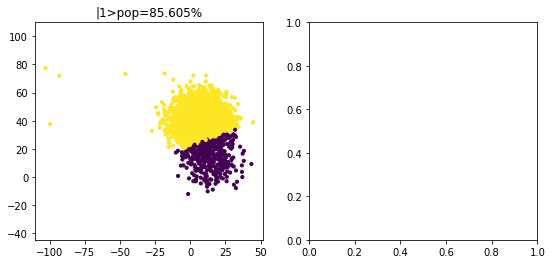

In [88]:
# sns.reset_orig()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(1):
    i=0
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_on, 0
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent1 = list(y).count(which)/len(y)
    onwhich[measure.qubitToread[i]] = (which if percent1 > 0.5 else 1-which)
    offwhich[measure.qubitToread[i]] = (1-which if percent1 > 0.5 else which)
    percent_on = list(y).count(onwhich[measure.qubitToread[i]])/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|1>pop={round(percent_on*100,3)}%')
    ax.axis('equal')
plt.show()
measure.onwhich = onwhich
measure.offwhich = offwhich

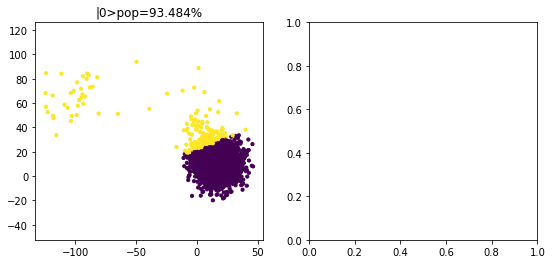

In [98]:
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(1):
    i = 0
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_off, measure.offwhich[measure.qubitToread[i]]
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent_off = list(y).count(which)/len(y)
    readmatrix[measure.qubitToread[i]] = np.mat([[percent_off,1-percent_on],[1-percent_off,percent_on]])
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|0>pop={round(percent_off*100,3)}%')
    ax.axis('equal')
plt.show()
measure.readmatrix = readmatrix

In [99]:
readmatrix

{'q7': matrix([[0.93484043, 0.14394947],
         [0.06515957, 0.85605053]])}

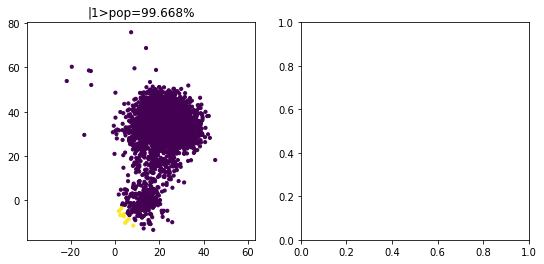

In [154]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(1):
    i = 0
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_on, onwhich[measure.qubitToread[i]] 
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent = list(y).count(which)/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|1>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()

# JPA饱和功率

In [260]:
async def SaturationPower(readamp):
    n = measure.n
    for k in readamp:
        measure.readamp = [k]
        await cww.modulation_read(measure,measure.delta,readlen=measure.readlen,repeats=500)
        await cww.couldRun(measure.awg['awgread'])
        sm = []
        for j in ['OFF','ON']:
            await psg_pump.setValue('Output',j)
#             x = await psg_pump.getValue('Output')
#             print(x)
#             time.sleep(0.5)
            ch_A, ch_B,I,Q = await ats.getIQ()
            Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
            s = Am + 1j*Bm
#             print(j,np.abs(s))
            sm.append(s)
        yield [k]*n, sm[1]/sm[0]

Output()

<IPython.core.display.Javascript object>


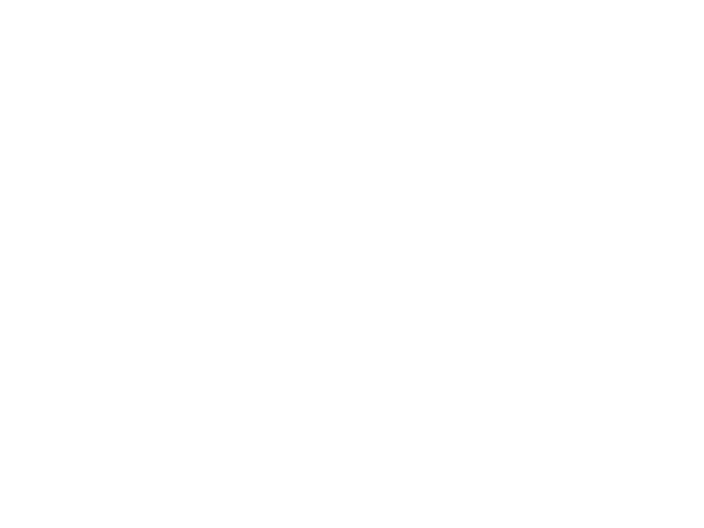

In [262]:
readamp = np.linspace(0.01,0.36,36)
await mrw.jpa_switch(measure,'ON')
await psg_ex1.setValue("Output",'OFF')
job = Job(SaturationPower, (readamp,), tags=['jpa'], max=len(readamp))
a_sp, s_sp = await job.done()
fig = plt.figure(num='jpa')
plt.plot(a_sp,20*np.log10(np.abs(s_sp)),'-o')
# plt.legend(loc=4,labels=['q%d'%(i+1) for i in range(10)])
plt.show()

<IPython.core.display.Javascript object>


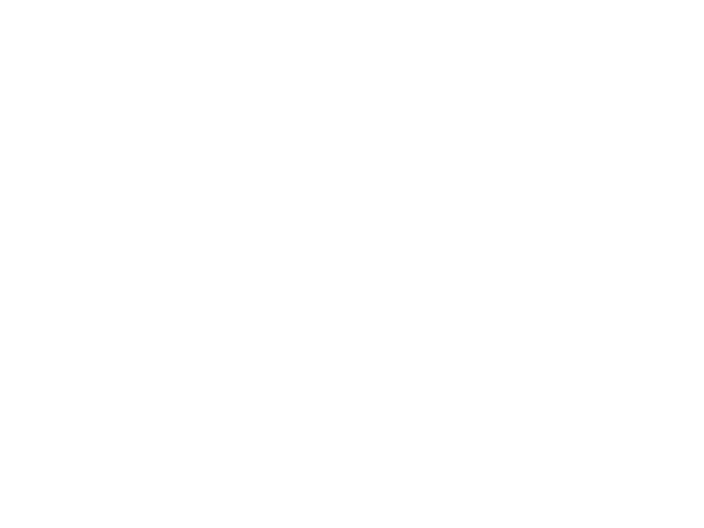

In [152]:
fig = plt.figure(num='jpa')
plt.plot(a_sp,20*np.log10(np.abs(s_sp)),'-.')
# plt.legend(loc=4,labels=['q%d'%(i+1) for i in range(10)])
plt.show()

In [956]:
measure.delta = np.array([30e6,70e6])

# 优化读出功率

In [115]:
fig = plt.figure(num='readamp')

<Figure size 432x288 with 0 Axes>

In [861]:
measure.delta

array([90750000., 50000000.])

In [114]:
q_target, which = q10, measure.onwhich
readamp = np.linspace(-0.5*measure.readamp,0.5*measure.readamp,51) + measure.readamp
# await measure.attinst['com8'].set_att(29)
await mrw.jpa_switch(measure,'ON')
for i in ['OFF','ON']:
    ex_lo_state = i
    await measure.psg[q_target.inst['ex_lo']].setValue('Output',ex_lo_state)
    job = Job(mrw.readpowerOpt, (measure,which,readamp), tags=[q_target.q_name], max=len(readamp))
    v_r, pop_r = await job.done()
    plt.figure(num='readamp')
    plt.plot(v_r,pop_r,'-.',label=ex_lo_state)
    plt.legend(loc='best')
    plt.show()

Output()

Output()

In [64]:
measure.readamp 

0.07500000000000001

In [319]:
readamp

array([0.1125, 0.117 , 0.1215, 0.126 , 0.1305, 0.135 , 0.1395, 0.144 ,
       0.1485, 0.153 , 0.1575, 0.162 , 0.1665, 0.171 , 0.1755, 0.18  ,
       0.1845, 0.189 , 0.1935, 0.198 , 0.2025, 0.207 , 0.2115, 0.216 ,
       0.2205, 0.225 , 0.2295, 0.234 , 0.2385, 0.243 , 0.2475, 0.252 ,
       0.2565, 0.261 , 0.2655, 0.27  , 0.2745, 0.279 , 0.2835, 0.288 ,
       0.2925, 0.297 , 0.3015, 0.306 , 0.3105, 0.315 , 0.3195, 0.324 ,
       0.3285, 0.333 , 0.3375])

# Crosstalk矫正

In [19]:
q2.state[1:]

[array([2.3465e+08, 2.1680e+08, 1.9200e+08, 1.7200e+08, 1.4930e+08,
        1.3745e+08, 1.3120e+08, 9.0750e+07, 7.0150e+07, 5.0000e+07]),
 array([-2.02791966+1.98358918j,  0.94964959+0.4076137j ,
         0.45040781-0.96442989j,  0.57294871+1.08435417j,
        -0.65608159+0.8892474j ,  1.49922606+0.18699409j,
         0.27348558-0.38805388j,  0.08288527+1.49532472j,
        -1.98253305+0.78429459j, -0.84952816-2.57848346j]),
 1500]

In [16]:
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]

v_rabi = np.linspace(-0.02,0.02,101)
measure.readamp = [0.03]
measure.ringup = [100]
measure.ringupamp = [0.1]
for v, k in enumerate(bits[7:],start=7):
    count = 0
    q_target = k
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await cww.RecoverInst(measure,state=q_target.state[0])
    measure.delta = measure.delta[v:(v+1)]
    #measure.readamp = 0.3
    await cww.modulation_read(measure,measure.delta,measure.readlen)
    await awg133.run()
    f_list = await ats.getValue('f_list')
#     await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
    for i,j in enumerate(bits):
        comwave = True if count == 0 else False
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag,f_list)
            job = Job(mrw.crosstalkSpec, (measure,v_rabi,[q_bias.q_name],[q_target.q_name],comwave), tags=[tag], max=11)
            v_ex, v_bias, s_sc = await job.done()
            await measure.awg[q_bias.inst['z_awg']].update_waveform(np.zeros((250000,)),f"ch{q_bias.inst['z_ch'][0]}")
            count += 1
    await cww.InitInst(measure,psgdc=True,awgch=True)
    await measure.awg[q_target.inst['z_awg']].update_waveform(np.zeros((250000,)),f"ch{q_target.inst['z_ch'][0]}")                                                                

q8_q1 [90900000.]


Output()

q8_q2 [90900000.]


Output()

q8_q3 [90900000.]


Output()

q8_q4 [90900000.]


Output()

q8_q5 [90900000.]


Output()

q8_q6 [90900000.]


Output()

q8_q7 [90900000.]


Output()

q8_q9 [90900000.]


Output()

q8_q10 [90900000.]


Output()

q9_q1 [70300000.]


Output()

q9_q2 [70300000.]


Output()

q9_q3 [70300000.]


Output()

q9_q4 [70300000.]


Output()

q9_q5 [70300000.]


Output()

q9_q6 [70300000.]


Output()

q9_q7 [70300000.]


Output()

q9_q8 [70300000.]


Output()

q9_q10 [70300000.]


Output()

q10_q1 [50000000.]


Output()

q10_q2 [50000000.]


Output()

q10_q3 [50000000.]


Output()

q10_q4 [50000000.]


Output()

q10_q5 [50000000.]


Output()

q10_q6 [50000000.]


Output()

q10_q7 [50000000.]


Output()

q10_q8 [50000000.]


Output()

q10_q9 [50000000.]


Output()

In [16]:
measure.n = 1

# 真空拉比

In [21]:
q1.replace(envelopename=['hanning',1],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=300e6,pi_len=30e-9,\
         seqtype='PDD',detune=3e6,DRAGScaling=None)
q2.replace(envelopename=['hanning',1],nwave=1,amp=1,shift=0e-9,phase=0,phaseDiff=0,delta_ex=110e6,pi_len=40e-9,\
         seqtype='PDD',detune=3e6,DRAGScaling=None)

In [476]:
q2.timing['read>xy'] = 500e-9
# q2.timing['z>xy'] = 300e-9

In [163]:
t_rabi, v_rabi = np.linspace(0,100,101), np.linspace(-0.02,0.02,21) + (-0.061)
# t_rabi = np.array([20])
# v_rabi = np.linspace(0.03,0.06,16)
mode = 'vbroadcast'
for i in [0]:
    imAmp = i
    # await psg[measure.qubits[q_target].inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex))
    job = Job(mrw.vRabi, (measure,t_rabi,v_rabi,mode,['q10'],['q9'],imAmp), tags=[f'modulation={imAmp}','dc-q10','ex-q9'], max=len(v_rabi))
    vv, tv, sv = await job.done()
    clear_output()

Output()

TypeError: cannot unpack non-iterable NoneType object

In [455]:
q2.timing = {'z>xy': -2e-09, 'read>xy': 0e-9}

In [60]:
measure.qubits['q10'].asdict()

{'q_name': 'q10',
 'inst': {'z_awg': 'awg131',
  'z_ch': [5],
  'ex_awg': 'awg134',
  'ex_ch': [2, 6],
  'ex_lo': 'psg_ex1',
  'com': 'com3'},
 'T_bias': [2.966, 0.068],
 'T_z': [1.743, 0.24],
 'specfunc': 1.100570041495*(0.799797230220902*tan(1.05818052116834*x - 0.0719562754394469)**2 + 1)**(1/4)*sqrt(Abs(cos(1.05818052116834*x - 0.0719562754394469))) - 0.281007883786446,
 'specfunc_cavity': sqrt((1.100570041495*(0.799797230220902*tan(1.05818052116834*x - 0.0719562754394469)**2 + 1)**(1/4)*sqrt(Abs(cos(1.05818052116834*x - 0.0719562754394469))) - 6.89483714603135)**2 + 2.74286987210981)/2 + 0.5502850207475*(0.799797230220902*tan(1.05818052116834*x - 0.0719562754394469)**2 + 1)**(1/4)*sqrt(Abs(cos(1.05818052116834*x - 0.0719562754394469))) + 3.16641068922923,
 'photonnum_func': None,
 'bias': 0.15,
 'zpulse': None,
 'f_lo': array([6.576e+09]),
 'delta': array([50000000.]),
 'f_ex': 5390000000.0,
 'delta_ex': 300000000.0,
 'alpha': 266000000.0,
 'power_ex': 60,
 'power_rabi': 30,
 'pi_

In [255]:
# zCali = measure.qubits['q2'].zCali
zCali

{'1st': {'pexp': array([ 6.29314047e-04,  2.32565457e-01,  2.64029906e-01, -4.14479389e-03,
          5.55472525e-04, -1.23407503e+00,  9.30718056e-03,  2.61476877e+00,
          8.75207640e-03, -1.39702942e+00,  8.29201701e-03]),
  'ppoly': array([-1.17449357e-27,  5.37716985e-01,  6.70675683e-01, -1.24462921e+02,
          9.09558140e+03, -3.28158675e+05,  5.85562704e+06, -4.11558808e+07,
          1.00000000e-10,  1.00000000e-10,  1.00000000e-10,  1.00000000e-10,
          1.00000000e-10,  1.00000000e-10,  1.00000000e-10,  1.00000000e-10,
          1.00000000e-10,  1.00000000e-10,  1.00000000e-10,  1.00000000e-10,
          1.00000000e-10,  1.00000000e-10,  1.00000000e-10,  1.00000000e-10,
          1.00000000e-10,  1.00000000e+00]),
  'time': [90, 0, 15, 0.4]},
 '2nd': {'pexp': array([-0.00044072]),
  'ppoly': array([-2.08329771e-26,  6.97004862e-01, -9.17710290e+00,  1.38847442e+03,
         -8.35667040e+04,  2.50944734e+06, -3.76334220e+07,  2.25512485e+08,
          1.00000000e-

## 单条扫电压

In [134]:
t_rabi, v_rabi = 20e-9, np.linspace(-0.02,0.02,101) + (-0.061)

# v_rabi = np.linspace(0.03,0.06,16)
mode = 'vbroadcast'
imAmp = 0

qubit_ex = measure.qubits['q9']
namelist = [f'ch{i}' for i in qubit_ex.inst['ex_ch']]
chlist = qubit_ex.inst['ex_ch']
awg_ex = measure.awg[qubit_ex.inst['ex_awg']]
pulselist = await cww.funcarg(cww.rabiWave,qubit_ex,shift=t_rabi)
await cww.writeWave(measure,awg_ex,name=namelist,pulse=pulselist)
await cww.couldRun(measure,awg_ex,chlist,namelist)

job = Job(mrw.singleVrabi, (measure,v_rabi,t_rabi,mode,['q10'],['q9'],imAmp), tags=['dc-q10','ex-q9'],avg=True, max=300)
vv, sv = await job.done()

Output()

In [ ]:
await psg_ex1.setValue('Frequency',(q9.f_ex+q9.delta_ex))

In [135]:
vv[:,1][np.argmax(np.abs(sv[:,1]))]

-0.06540000000000007

## 单条扫时间

In [ ]:
t_rabi, v_rabi = np.linspace(0,100,101), -0.061

mode = 'vbroadcast'
imAmp = 0
dcstate, exstate = ['q10'], ['q9']

task_z = await executeZseq(measure,cww.Z_sequence,len_data,True,mode=mode,dcstate=dcstate,\
    v_or_t=t_rabi/1e9,arg='during',volt=j,delta_im=0e6,imAmp=imAmp)
concurrence(task_z)
job = Job(rabi_seq, (measure,t_rabi,'shift',exstate,True,True,mode), tags=exstate, max=300,avg=True)
t_t, s_t = await job.done()

# 纵场调制

In [190]:
q10.volt = -0.0654
q9.volt = 0
data = np.load(r'D:/QuLabData/2020/1008/crosstalk_cali/zheng_crosstalk_q1-10_20201008222347.npz')
calimatrix = np.mat(data['mat'])
fc,vtarget = dt.specshift(q10.specfuncz,q10.f_ex/1e9,q10.volt)
fc1,vtarget = dt.specshift(q9.specfuncz,q9.f_ex/1e9,q9.volt)
fc,fc1

(5.225937714381744, 5.224614823491413)

In [191]:
q9.phaseim = 2.5
q10.phaseim = 0
q10.f_ex = q10.f_ex - 158.75e6

5390200000.0

In [66]:
measure.qubits['q9'].asdict()

{'q_name': 'q9',
 'inst': {'z_awg': 'awg131',
  'z_ch': [1],
  'ex_awg': 'awg133',
  'ex_ch': [2, 6],
  'ex_lo': 'psg_ex1',
  'com': 'com3'},
 'T_bias': [2.631, -0.184],
 'T_z': [1.629, -0.128],
 'specinterp': [array([4.16503571, 4.16504576, 4.1650558 , ..., 5.3881712 , 5.38817139,
         5.38817159]),
  array([-0.5       , -0.49999808, -0.49999616, ..., -0.02000384,
         -0.02000192, -0.02      ])],
 'specfunc': 1.5973401693829*(0.91580251930948*tan(1.19363906036943*x + 0.171884024693199)**2 + 1)**(1/4)*sqrt(Abs(cos(1.19363906036943*x + 0.171884024693199))) - 0.682533400674553,
 'specfuncz': [5.77489162283576*(0.0126845778676501*tan(1.85339027027126*x + 0.017939641923017)**2 + 1)**(1/4)*sqrt(Abs(cos(1.85339027027126*x + 0.017939641923017))) - 0.386198491277849,
  -0.009679365544738376,
  1.6950518754638708,
  10.794116888297738,
  0.3861984912778487,
  0.1126258312628597],
 'specfunc_cavity': sqrt((1.5973401693829*(0.91580251930948*tan(1.19363906036943*x + 0.171884024693199)**2 

In [15]:
t_rabi, v_rabi = np.linspace(0,250,251), np.linspace(0,0.4,41)
mode = 'vbroadcast'
job = Job(mrw.vModulation, (measure,t_rabi,v_rabi,mode,['q10'],['q9'],calimatrix), tags=['dc-q10','ex-q9'], max=len(v_rabi))
vv, tv, sv = await job.done()
clear_output()

## population

In [197]:
t_rabi, v_rabi = np.linspace(3,203,201), np.linspace(0,0.45,26)
which = measure.onwhich
caliM = calimatrix[8:10,8:10]
delta_im = 120e6
await cww.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=1000,weight=None)
job = Job(mrw.vModulation_pop, (measure,t_rabi,v_rabi,['q10'],['q9'],caliM,which), tags=[f'{delta_im/1e6}MHz','dc-q10','ex-q9'], max=len(t_rabi))
vv, tv, sv = await job.done()
# clear_output()

Output()

In [191]:
during, imAmp = 0, 0
pulse_im = (wn.square(during,0e-9) << (during/2 ))
if 1 != 0:
    wav_I, wav_Q = wn.mixing(imAmp*pulse_im,phase=0.0,freq=120e6,ratioIQ=-1.0)
fc,vtarget = dt.specshift(q10.specfuncz,q10.f_ex/1e9,q10.volt)
    
fshift, = cww.pulseTowave((wav_I,))
vwindow, = cww.pulseTowave((pulse_im,))
bias = dt.biasshift(q10.specfuncz,fc,fshift) - vtarget*vwindow*imAmp

# 矫正相位

In [74]:
phase = np.linspace(0,2*np.pi,101)
caliM = calimatrix[8:10,8:10]
delta_im = 120e6
job = Job(mrw.phaseCali,(measure,phase,'vbroadcast',['q10'],['q9'],caliM),tags=[f'{delta_im/1e6}MHz','dc-q10','ex-q9'],max=300,avg=True)
pv, sv = await job.done()

Output()

# 矫正频率

In [161]:
q10.replace(nwave=0,seqtype='PDD',detune=0e6)

In [147]:
# -0.0654
volt = np.linspace(3,53,101) 
job = Job(mrw.freqCali,(measure,volt,'vbroadcast',['q10'],['q10']),tags=['dc-q10','ex-q10'],max=300,avg=True)
pv, sv = await job.done()

Output()

In [192]:
fc,vtarget

(5.219996629441422, -0.27751931870315905)

In [195]:
bias

array([1.32968163e-06, 1.32968163e-06, 1.32968163e-06, ...,
       1.32968163e-06, 1.32968163e-06, 1.32968163e-06])

In [201]:
dt.biasshift(q10.specfuncz,fc,0)

1.3296816263608235e-06

In [203]:
1/2**15

3.0517578125e-05

# Zpulse_XY

Output()

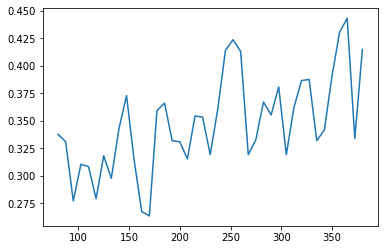

In [27]:
q_target = 'q2'
which, tshift, t_int = measure.offwhich, 3000, 20
tdelay = np.linspace(80,580,41)
caliparas = measure.qubits[q_target].zCali
await cww.ats_setup(measure.ats,measure.delta,l=measure.readlen,repeats=1000,weight=weight)
job = Job(mrw.zPulse_XY, (measure,tdelay,t_int,tshift,which,caliparas,[q_target]), tags=[q_target], max=len(tdelay))
t_xy, pop_xy = await job.done()
plt.figure()
plt.plot(t_xy,pop_xy)
plt.show()

In [292]:
async def optZpulse(t1,t2,t3,t4,t5,t6,t7,t8,t9,t10):
    caliparas = (t1,t2,t3,t4,t5,t6,t7,t8,t9,t10)
    job = Job(mrw.zPulse_XY, (measure,tdelay,t_int,tshift,which,caliparas,['q2']), tags=['q2'], max=len(tdelay))
    t_xy, pop_xy = await job.done()
    s = pop_xy[:,0]
    l = int(len(s)/3)
    return np.sum((s[:2*l]-np.mean(s[2*l:]))**2)

    
which, tshift, t_int = measure.offwhich, 5000, 20
tdelay = np.append(np.linspace(10,200,20),np.linspace(3000,4000,10))
    
start = [1.84e-9,0.0272,1.406e-8,-0.1765,2.183e-9,0,5.489e-7,-0.0172,8.57e-8,-0.0107]
senstive = np.abs(start)/2
args = measure,tdelay,t_int,tshift,which,['q10']
ret = opt.optimize(optZpulse,start,senstive,[3]*10,print_info=True,algorithm='minimize')

Output()

.o
[ 0.     0.027  0.    -0.176  0.     0.     0.    -0.017  0.    -0.011] 0.4055818557739258   .

Output()

.o
[ 0.     0.041  0.    -0.176  0.     0.     0.    -0.017  0.    -0.011] 0.008951187133789062   .

Output()

.o
[ 0.     0.027  0.    -0.088  0.     0.     0.    -0.017  0.    -0.011] 0.00548076629638672   ...

Output()

..

Output()

In [367]:
measure.onwhich

[0]

# pi脉冲振幅

In [1147]:
q_target = q10
t_rabi = np.linspace(1,501,201)
att_single = 35

com9 open...
last ATT 35.0
now ATT 35.0


Output()

<IPython.core.display.Javascript object>


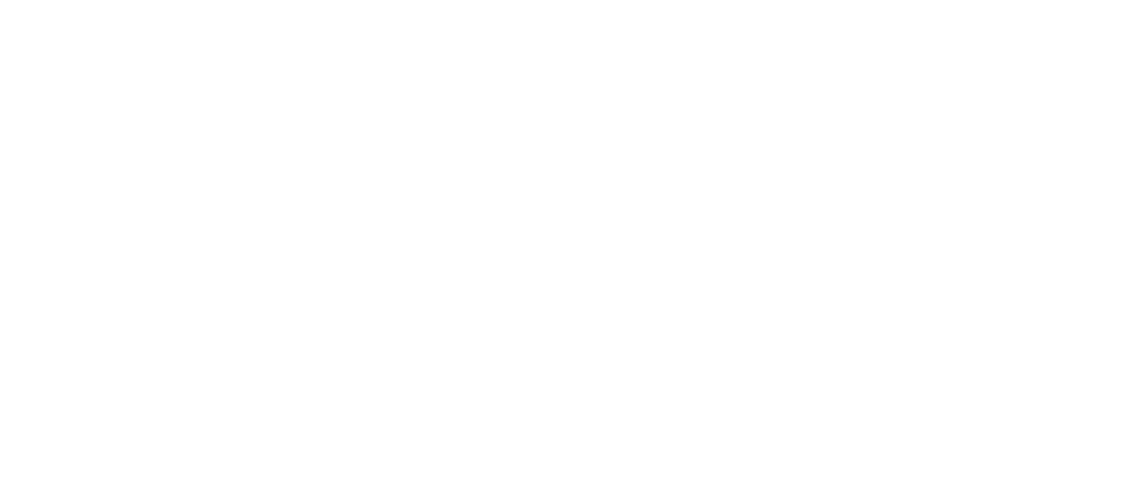

In [1149]:
tag = q_target.q_name
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseAmp, (q_target,measure,t_rabi), tags=[tag], max=9)
amp_pi, t_amp, s_amp = await job.done()
state = await mr.QueryInst(measure)
x, y , s = amp_pi[:,0], t_amp[0][:,0], s_amp[:,:,0]
wlist = [((op.RowToRipe().fourier(y,np.abs(i)))[0]) for i in s]
t_op = op.RowToRipe().firstMax(y,np.abs(s[-1]),num=0,peakpercent=0.7)
a = np.polyfit(x,wlist,1)
z = np.poly1d(a)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].set_yticks(x)
axes[1].plot(x,wlist,'.')
axes[1].plot(x,z(x))
axes[1].set_title(f'$grad={a[0]}$')
plt.show()

<IPython.core.display.Javascript object>


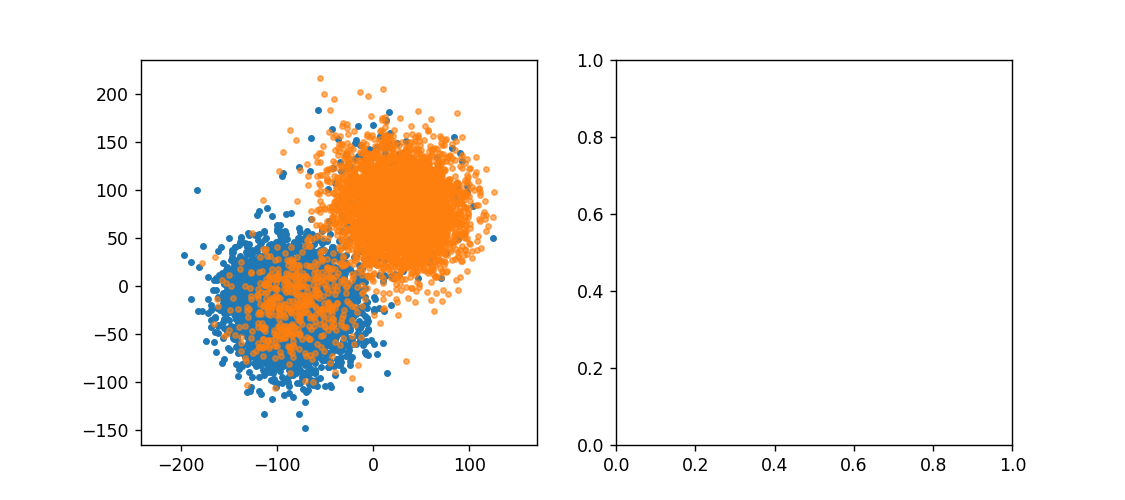

In [561]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st_Q[0,:,i], s_st_Q[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax.vlines([0],10,-100)
#     ax.hlines([0],-10,100)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


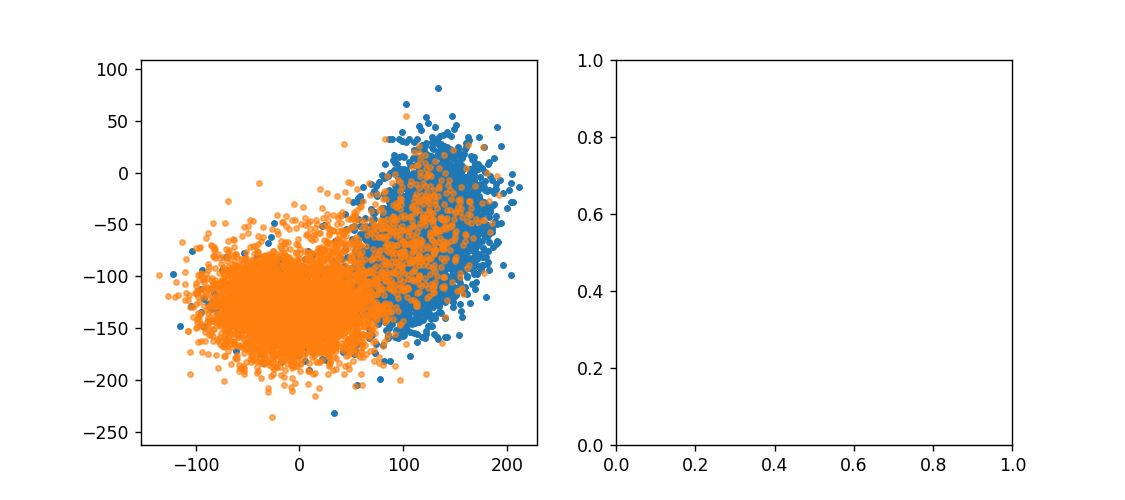

In [227]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
#     ax.vlines([0],10,-100)
#     ax.hlines([0],-10,100)
    ax.axis('equal')
plt.show()

## 测试

com7 open...
last ATT 13.5
now ATT 11.0


Output()

<IPython.core.display.Javascript object>


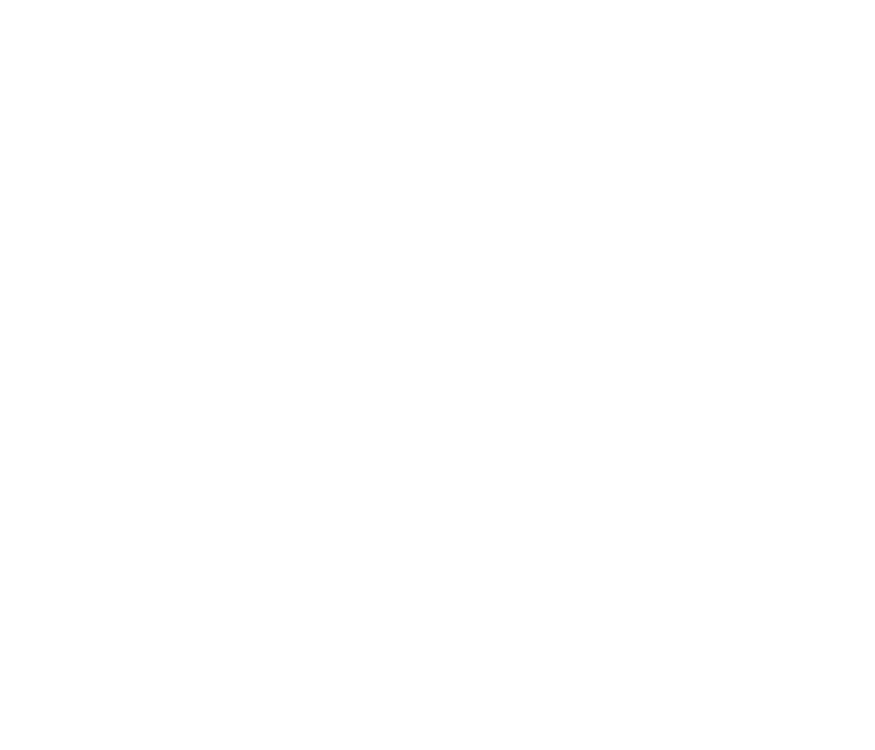

In [1134]:
exstate = {'q1':35,'q10':35}
# await measure.psg['psg_lo'].setValue('Power',13)
mr.Att_Setup(measure,'com7').Att(11)
job = Job(mr.threshHoldtest, (measure,True,exstate), tags=exstate.keys(), max=2)
st, s_st = await job.done()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


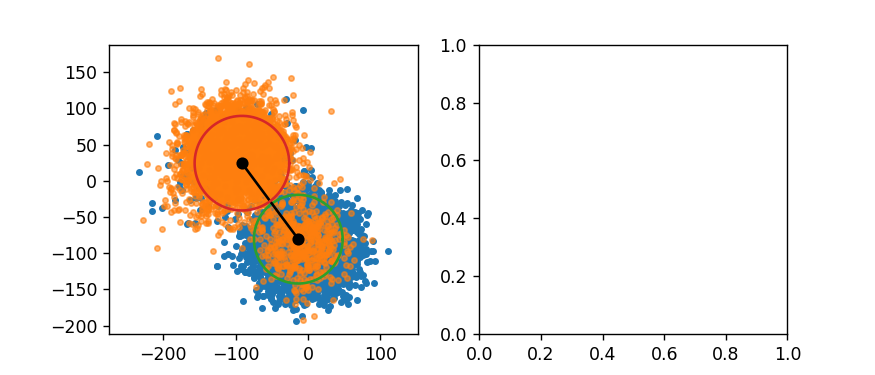

In [565]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(7,3*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    offmean, onmean = np.mean(x), np.mean(y)
    offstd, onstd = np.std(x), np.std(y)
    theta = np.arange(0, 2*np.pi, 0.01)
    roff = np.real(offmean) + offstd * np.cos(theta)
    ioff = np.imag(offmean) + offstd * np.sin(theta)
    ron = np.real(onmean) + onstd * np.cos(theta)
    ion = np.imag(onmean) + onstd * np.sin(theta)
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
    ax.plot(roff,ioff)
    ax.plot([np.real(offmean),np.real(onmean)],[np.imag(offmean),np.imag(onmean)],'k-o')
    ax.plot(ron,ion)
plt.show()

<IPython.core.display.Javascript object>


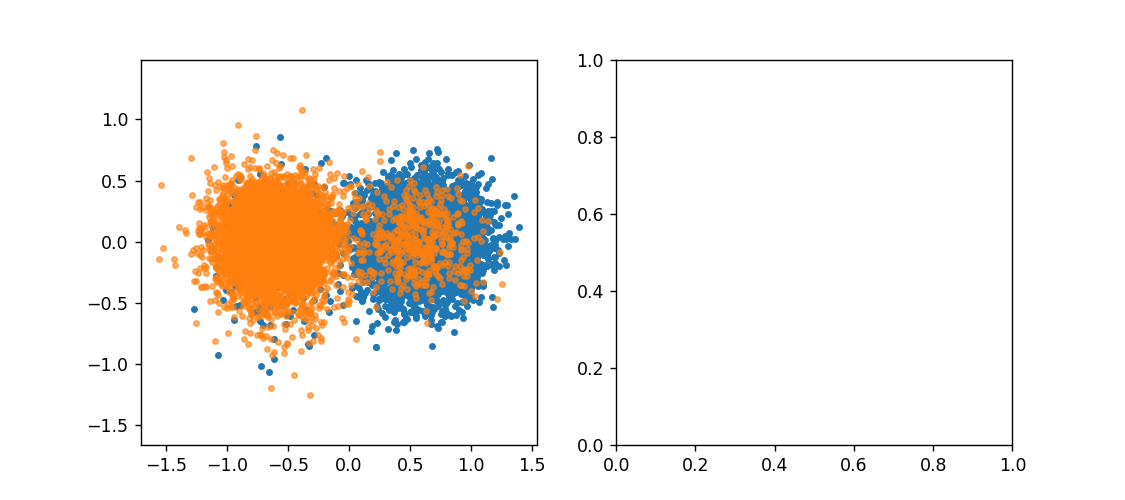

In [566]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ax = axes[i//2][i%2] if num>1 else axes[i]
    x, y = s_off, s_on
    add, diff = (np.mean(x)+np.mean(y))/2, np.mean(x)-np.mean(y)
    s_off, s_on = (x-add)/diff, (y-add)/diff
    ax.plot(np.real(s_off),np.imag(s_off),'.')
    ax.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
    ax.axis('equal')
plt.show()

In [252]:
measure.readlen

1200

In [1606]:
measure.qubitToread 

['q1']

0.4888251582278481


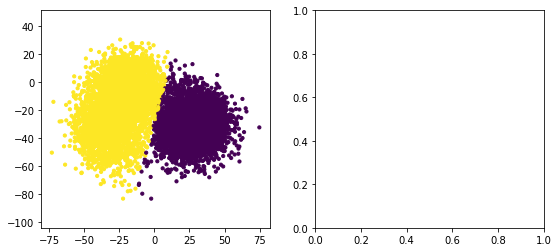

In [85]:
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
predict = {}
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    S = list(s_off) + list(s_on)
    x,z = np.real(S), np.imag(S)
    d = list(zip(x,z))
    kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
    kmeans.fit(d)
    predict[measure.qubitToread[i]] = kmeans.predict
    y = kmeans.predict(d)
    print(list(y).count(1)/len(y))
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(x,z,c=y,s=10)
    ax.axis('equal')
plt.show()
measure.predict = predict

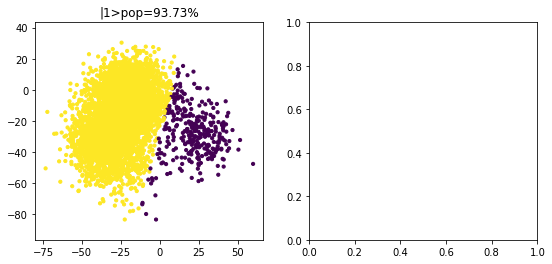

In [86]:
# sns.reset_orig()
num = measure.n//2+measure.n%2
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
onwhich, offwhich = [], []
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_on, 0
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent1 = list(y).count(which)/len(y)
    onwhich.append(which if percent1 > 0.5 else 1-which)
    offwhich.append(1-which if percent1 > 0.5 else which)
    percent = list(y).count(onwhich[i])/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|1>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()
measure.onwhich = onwhich
measure.offwhich = offwhich

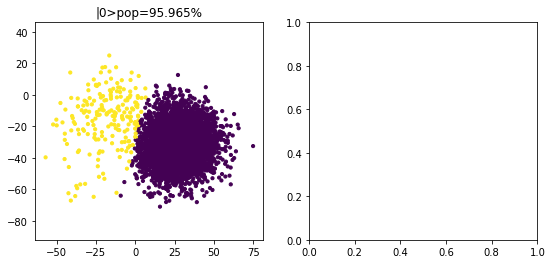

In [87]:
fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,4*num))
for i in range(measure.n):
    s_off, s_on = s_st[0,:,i], s_st[1,:,i]
    ss, which = s_off, measure.offwhich[i]
    d = list(zip(np.real(ss),np.imag(ss)))
    y = measure.predict[measure.qubitToread[i]](d)
    percent = list(y).count(which)/len(y)
    ax = axes[i//2][i%2] if num>1 else axes[i]
    ax.scatter(np.real(ss),np.imag(ss),c=y,s=10)
    ax.set_title(f'|0>pop={round(percent*100,3)}%')
    ax.axis('equal')
plt.show()

# rabiPopulation

com13 open...
last ATT 20.0
now ATT 20.0


Output()

<IPython.core.display.Javascript object>


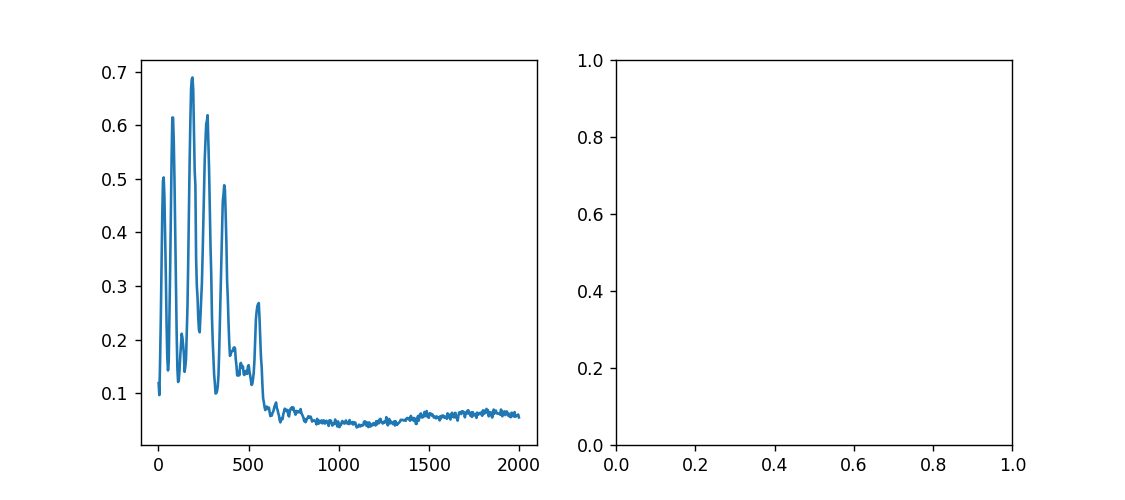

In [98]:
t_rabi, q_target, which = np.linspace(1,2001,501), q3, 1
att_single = 20
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
mr.Att_Setup(measure,q_target.inst['com']).Att(att_single)
await psg_ex2.setValue('Output','OFF')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPop, (q_target,measure,t_rabi,which), tags=[tag], max=len(t_rabi))
t_rp, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_rp[:,0],np.abs(pop[:,0]))
plt.show()

0.10700158227848101


<IPython.core.display.Javascript object>


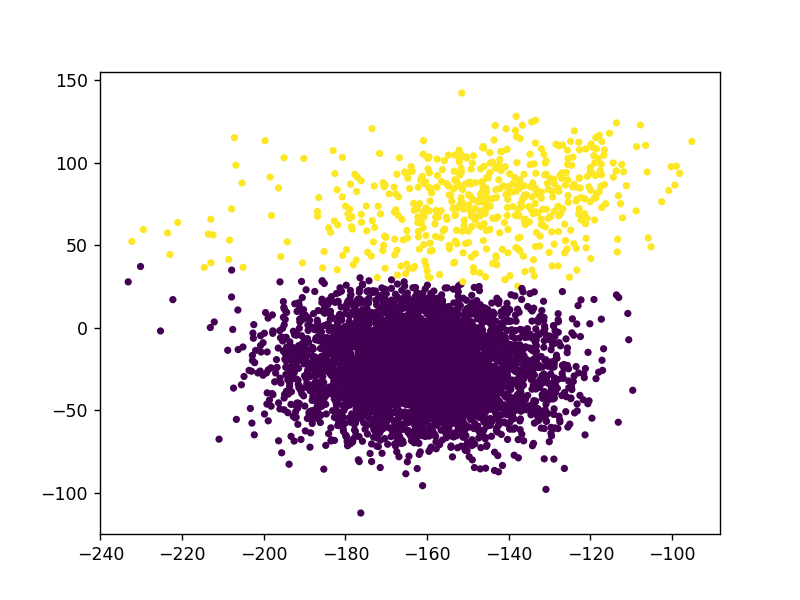

In [148]:
ss, which = pop[4,:,0], 1
d = list(zip(np.real(ss),np.imag(ss)))
y = measure.predict(d)
print(list(y).count(which)/len(y))
plt.figure()
plt.scatter(np.real(ss),np.imag(ss),c=y,s=10)
plt.show()

# 优化读出功率

Output()

<IPython.core.display.Javascript object>


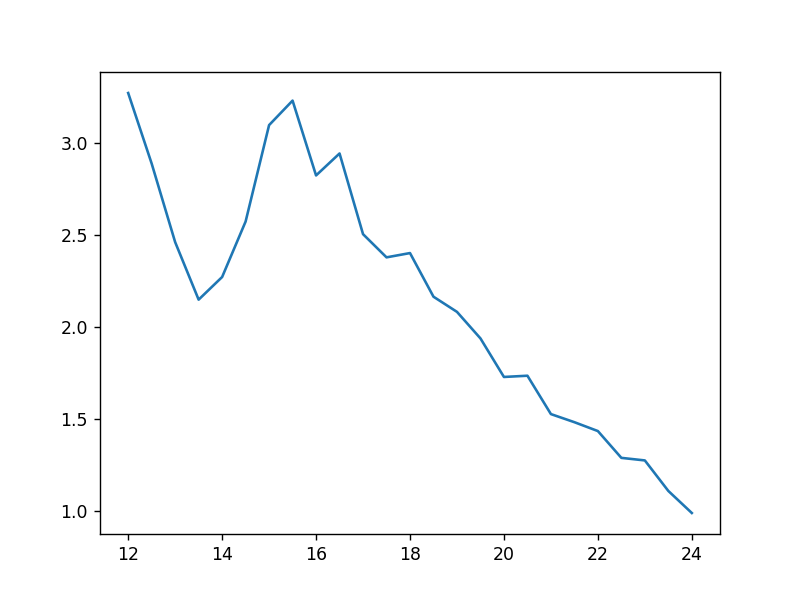

In [77]:
com, att = 'com7', np.linspace(12,24,25)
job = Job(mr.readpowerOpt, (q_target,measure,com,att), tags=[tag], max=len(att))
# attopt, popoff, popon = await job.done()
# plt.figure()
# plt.plot(attopt,popoff)
# plt.plot(attopt,popon)
# plt.show()
attopt, snr = await job.done()
plt.figure()
plt.plot(attopt,snr)
plt.show()

# pi脉冲优化

## sequance

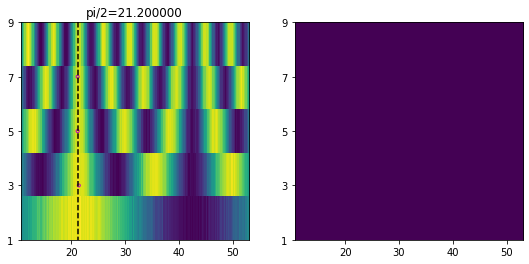

In [81]:
q_target, nwave, wavlen = q6, 5, len(t_rabi)
tag = q_target.q_name
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseOpt, (q_target,measure,nwave,wavlen), tags=[tag], max=nwave)
n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=22,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

In [82]:
q6 = q6._replace(pi_len=21.2,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])

## waveform

Output()

<IPython.core.display.Javascript object>


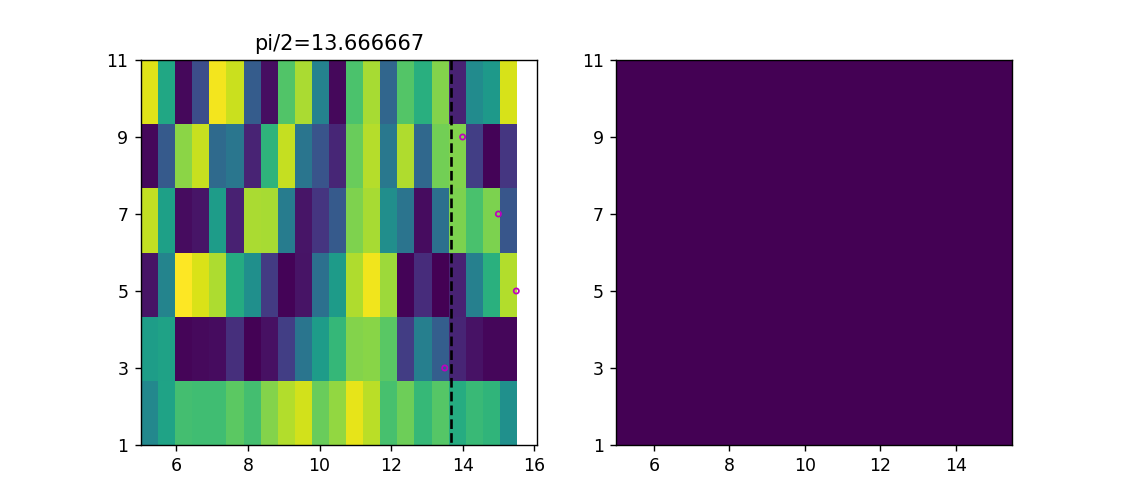

In [100]:
q_target, nwave, wavlen = q3, 6, len(t_rabi)
tag = q_target.q_name
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.pipulseOpt_waveform, (q_target,measure,nwave), tags=[tag], max=nwave)
n_pi, t_pi, s_pi = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
x, y, s = n_pi[:,0],t_pi[0][:,0], np.abs(s_pi[:,:,0])
index = y[np.argmax(np.abs(s),axis=1)[0]]
extent = [np.min(y),np.max(y),np.min(x),np.max(x)]
axes[0].set_yticks(x)
axes[0].imshow(np.abs(s),extent=extent,origin='lower',aspect='auto')
yop = np.array([op.RowToRipe().firstMax(y,z,num=16,peakpercent=0.9,insitu=True) for z in s])
axes[0].scatter(yop[1:-1],x[1:-1],marker='.',c='',edgecolors='m')
axes[0].vlines(np.mean(yop),np.max(x),np.min(x),'k','--')
axes[0].set_title('pi/2=%f'%np.mean(yop))
axes[1].set_yticks(x)
axes[1].imshow(np.angle(s),extent=extent,origin='lower',aspect='auto')
plt.show()

# pipulseDetune

Output()

Output()

Output()

<IPython.core.display.Javascript object>


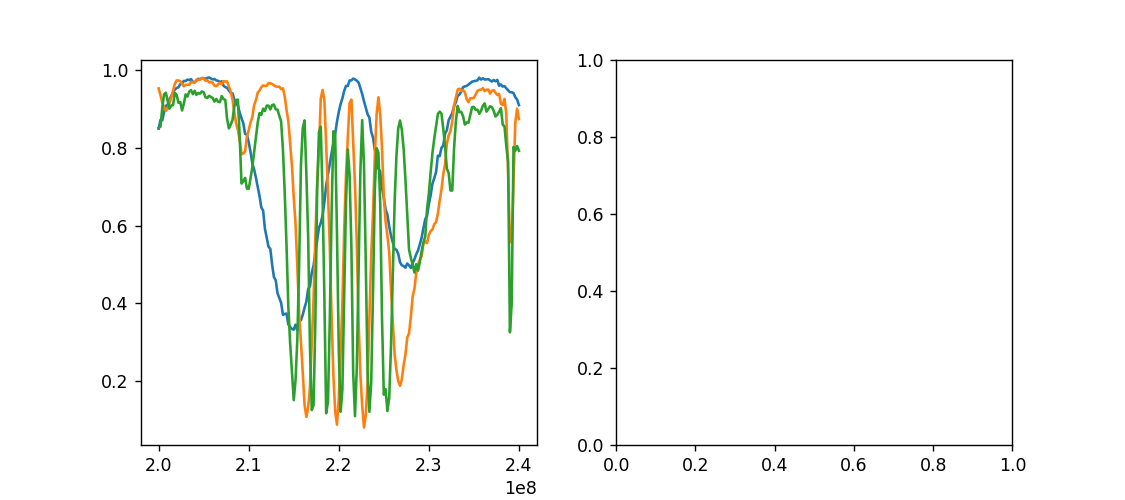

In [156]:
q_target, which = q6, measure.offwhich[0]
alpharatiodelta = -1/ q_target.alpha / (2*np.pi)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
popn = []
for i in (1,5,10):
    job = Job(mr.detuneOpt, (q_target,measure,which,alpharatiodelta,i), tags=[q_target.q_name], max=201)
    f_op, pop = await job.done()
    popn.append(pop)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
for i in range(len(popn)):
    x, y = f_op[:,0], popn[i][:,0]
    axes[0].plot(x,np.abs(y))
plt.show()

In [ ]:
x, y1, y2 = f_op[:,0], popn[0][:,0], popn[1][:,0]
# f01 = op.RowToRipe().firstMax(x,y,num=(q_target.f_ex+q_target.delta_ex)[0],peakpercent=0.7)
index = np.argmin(np.abs(y1-y2))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(x,np.abs(y1))
axes[0].plot(x,np.abs(y2))
axes[0].set_title('Delta_lo=%.4f MHz'%((x[index])/1e6))
plt.show()

# DragcoefHD

Output()

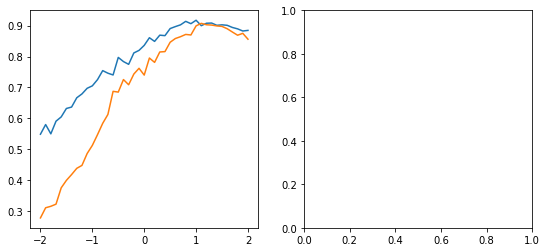

In [89]:
q_target, which, axis = q6, measure.onwhich[0], [['Xnhalf','Xhalf'],['Ynhalf','Yhalf']]
alpha = q_target.alpha * (2*np.pi)
# await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.dragcoefHD, (q_target,measure,which,alpha,axis,3), tags=[q_target.q_name], max=82)
f_op, s_op = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
l = np.shape(f_op)[0]//2
f1, f2, s1, s2 = f_op[:l,0], f_op[l:,0], np.abs(s_op[:l,0]), np.abs(s_op[l:,0])
axes[0].plot(f1,np.abs(s1))
axes[0].plot(f2,np.abs(s2))
plt.show()

# IQ-Mixer优化相位

Output()

<IPython.core.display.Javascript object>


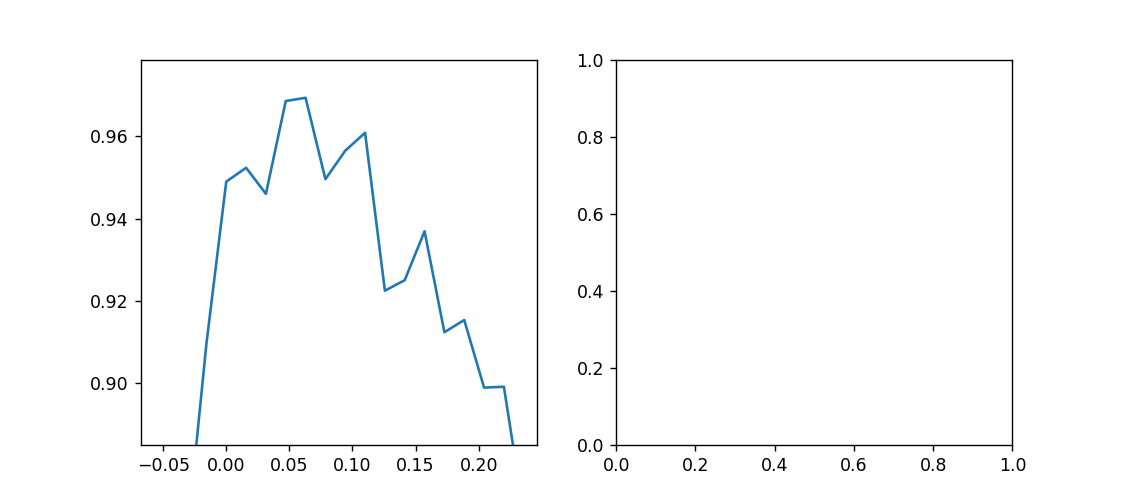

In [106]:
q_target, which = q6, measure.offwhich[0]
alpha = q_target.alpha
job = Job(mr.IQphaseOpt, (q_target,measure,which,5,alpha), tags=[q_target.q_name], max=201)
phase_op, pop = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(phase_op[:,0],np.abs(pop[:,0]))
plt.show()

In [84]:
await psg_ex1.setValue('Frequency',4.0576e9)

In [1232]:
qubit = q5
name, awg_target = [qubit.q_name+'_I', qubit.q_name+'_Q'], measure.awg[qubit.inst['ex_awg']]
await cw.genwaveform(measure,awg_target,name,qubit.inst['ex_ch'])
await cw.modulation_read(measure,measure.delta,tdelay=measure.readlen)
await measure.psg[qubit.inst['ex_lo']].setValue('Frequency',(qubit.f_ex)[0])
await measure.psg['psg_lo'].setValue('Output','ON')
ch1, ch2 = qubit.inst['ex_ch']
    
async def awgoffset(offset1,offset2):
    await awg_target.stop()
    await awg_target.setValue('Offset',offset1,ch=ch1)
    await awg_target.setValue('Offset',offset2,ch=ch2)
    await cw.couldRun(awg_target)
    await measure.psg[qubit.inst['ex_lo']].setValue('Output','ON')
    ch_A, ch_B = await measure.ats.getIQ()
    Am, Bm = ch_A.mean(axis=0),ch_B.mean(axis=0)
    theta0 = np.angle(Am) - np.angle(Bm)
    Bm *= np.exp(1j*theta0)
    s = Am + Bm
    await measure.psg[qubit.inst['ex_lo']].setValue('Output','OFF')
    return np.abs(s - measure.base)

In [1233]:
# await cw.ats_setup(ats18,np.array([50e6]),l=1500,repeats=500)
opt.optimize(awgoffset,[-0.1,-0.5],[0.01,0.01],[3,3],high=[2,2],low=[-2,-2],print_info=True,algorithm='basinhopping')

.o
[-0.1 -0.5] [73.37549395]   .o
[-0.105 -0.5  ] [68.13018893]   ......................o
[-0.105 -0.501] [67.74947406]   .........................................................................o
[ 0.329 -0.831] [67.32442623]   ......................................................................................................................................................................................................................................................................................................o
[-0.115 -1.392] [66.53918799]   ...........................................................................................................................................................................................................................................................................................................................................................................................................................................................

                        fun: 53.40129378817715
 lowest_optimization_result:  final_simplex: (array([[-1.32537874, -0.79252065],
       [-1.32535275, -0.79256951],
       [-1.32529417, -0.79259195]]), array([53.40129379, 53.40129379, 53.40129379]))
           fun: 53.40129378817715
       message: 'Optimization terminated successfully.'
          nfev: 50
           nit: 19
        status: 0
       success: True
             x: array([-1.32537874, -0.79252065])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1518
                        nit: 30
                          x: array([-1.325, -0.793])

# ramseyZpulse

Output()

<IPython.core.display.Javascript object>


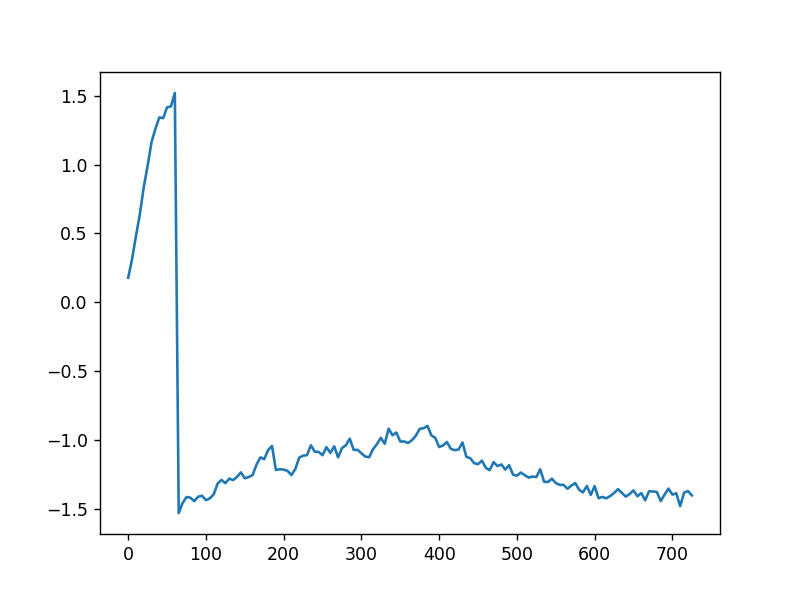

In [73]:
q_target, which, tcali = q6, measure.onwhich[0], 200
dragcoef = None
tdelay = np.arange(0,800,(q_target.pi_len/2),dtype=int)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.ramseyZpulse, (q_target,measure,tdelay,which,tcali,dragcoef), tags=[q_target.q_name], max=len(tdelay))
t_rz, poplist_rz = await job.done()
coordinate = [[1-2*j[i] for i in range(2)] for j in poplist_rz]
theta = np.array([np.arctan(i[1]/i[0]) for i in coordinate])
plt.figure()
plt.plot(t_rz,theta)
plt.show()

In [59]:
j = 0
theta_new = []
theta_new.append(theta[0])
for i,j in enumerate(theta[1:],start=1):
    if theta_new[i-1]-j>np.pi/2:
        theta_new.append(j+np.pi/2)
    if theta_new[i-1]-j<-np.pi/2:
        theta_new.append(j-np.pi/2)

NameError: name 'theta' is not defined

# RamseyZpulse_chen

In [640]:
q_target, which, tcali = q6, measure.onwhich[0], 190
dragcoef = None
tdelay = np.arange(0,400,(q_target.pi_len/2),dtype=int)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
t_rz,poplist_rz = [], []
for nozpulse in [True,False]:
    job = Job(mr.ramseyZpulse_chen, (q_target,measure,tdelay,which,tcali,dragcoef,nozpulse), tags=[q_target.q_name], max=len(tdelay))
    t, pop = await job.done()
    t_rz.append(t)
    poplist_rz.append(pop)

Output()

Output()

In [414]:
def test(theta):
    j = 0
    theta_new = []
    theta_new.append(theta[0])
    for i,j in enumerate(theta[1:],start=1):
        while 1:
            if theta_new[i-1]>j+0.8:
                j += np.pi
            else:
                break
        theta_new.append(j)
    return np.array(theta_new)

<IPython.core.display.Javascript object>


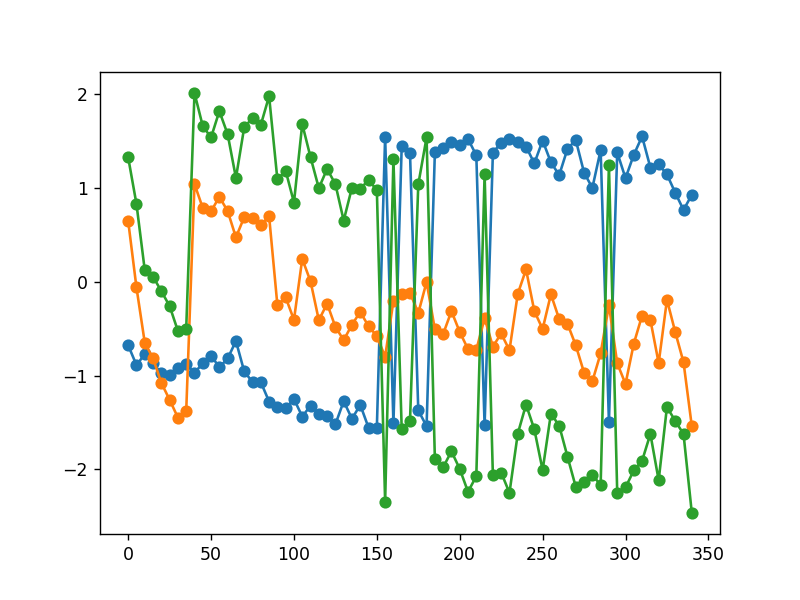

In [641]:
plt.figure()
t = t_rz[0][:,0]
pop_ref, pop_rz = poplist_rz[0], poplist_rz[1]
coordinate_ref = [[1-2*j[i] for i in range(2)] for j in pop_ref]
coordinate_rz = [[1-2*j[i] for i in range(2)] for j in pop_rz]
theta_ref = np.array([np.arctan(i[1]/i[0]) for i in coordinate_ref])
theta_rz = np.array([np.arctan(i[1]/i[0]) for i in coordinate_rz])

# theta_ref = test(theta_ref)
plt.plot(t,theta_ref,'-o')
# theta_rz = test(theta_rz)
plt.plot(t,theta_rz,'-o')
deltatheta = theta_rz - theta_ref
# deltatheta = test(deltatheta)
plt.plot(t,deltatheta,'-o')
plt.show()

In [398]:
np.shape(coordinate_rz)

(84, 2)

In [400]:
c 

[[0.163370253164557, 0.5688291139240507, 0],
 [0.08267405063291144, 0.5280854430379747, 0],
 [0.09335443037974689, 0.5704113924050633, 0],
 [0.08504746835443033, 0.5862341772151899, 0],
 [0.24564873417721522, 0.5803006329113924, 0],
 [0.24683544303797467, 0.5751582278481013, 0],
 [0.2784810126582279, 0.5510284810126582, 0],
 [0.02373417721518989, 0.4489715189873418, 0],
 [0.015427215189873444, 0.5344145569620253, 0],
 [-0.028481012658227778, 0.5284810126582278, 0],
 [0.15625, 0.5569620253164558, 0],
 [0.153876582278481, 0.5427215189873418, 0],
 [0.06685126582278478, 0.45767405063291144, 0],
 [0.27966772151898733, 0.4932753164556962, 0],
 [0.12223101265822789, 0.492879746835443, 0],
 [0.0035601265822784445, 0.4058544303797469, 0],
 [-0.015427215189873333, 0.461629746835443, 0],
 [-0.054193037974683556, 0.4612341772151899, 0],
 [-0.18868670886075956, 0.2689873417721519, 0],
 [-0.11867088607594933, 0.2954905063291139, 0],
 [-0.1586234177215189, 0.3817246835443038, 0],
 [-0.202136075949367

In [397]:
np.arctan(coordinate_rz[9][1]/coordinate_rz[9][0])

-1.5169561948215944

<IPython.core.display.Javascript object>


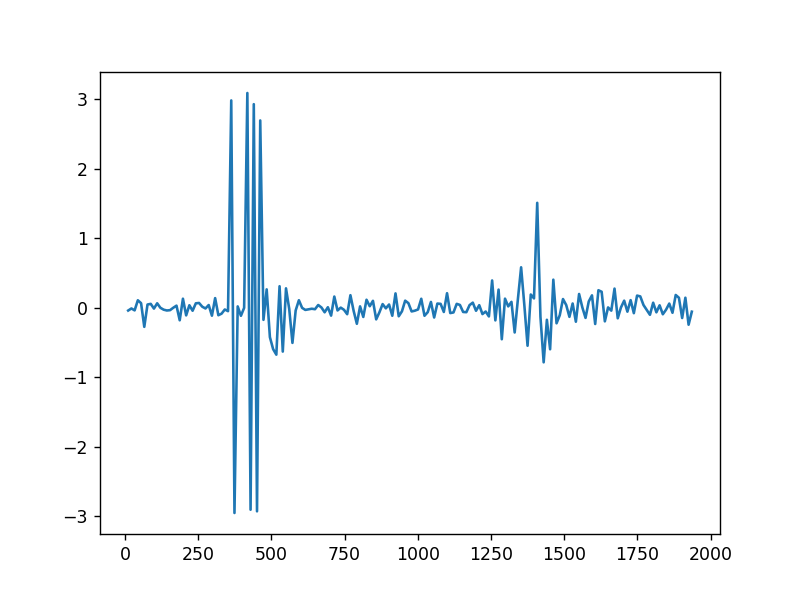

In [233]:
plt.figure()
deltatheta = np.diff(deltatheta)
plt.plot(t[1:],deltatheta)
plt.show()

# CrossTalk矫正

In [ ]:
t_rabi = np.linspace(0,100,201)
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
z_crosstalk = np.ones((10,10))

In [ ]:
# fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(28,28))
%matplotlib inline
await mr.jpa_switch(measure,'ON')
for v,k in enumerate(bits,start=0):
    q_target = k
    print(q_target.q_name)
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
    for i,j in enumerate(bits):
        q_bias = j
        tag = q_target.q_name + '_' + q_bias.q_name
        if q_bias == q_target:
            if q_target.f_ex[0] > 3.9e9:
                v_rabi = np.linspace(-0.5,0.5,201)
            else:
                v_rabi = np.linspace(-0.05,0.05,201)
        else:
            v_rabi = np.linspace(-1,1,201)
        job = Job(mr.Z_cross, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=500,avg=True)
        v_Z, s_Z = await job.done()
#         await awg131.use_waveform(name='test',ch=i+1)
        await mr.InitInst(measure,psgdc=False,awgch=True)
        try:
            A, C, W, phi = op.Cos_Fit().fitCos(v_Z[:,0], np.abs(s_Z[:,0]))
        except Exception or RuntimeWarning:
            print('bad fitting')
            A, C, W, phi =0,0,0,0
        z = A*np.cos(2*np.pi*W*v_Z+phi)+C
        v_op = op.RowToRipe().firstMax(v_Z[:,0],np.abs(z[:,0]),num=0)
        W = -W if v_op < 0 else W
        z_crosstalk[v,i] = W
        plt.figure()
        plt.plot(v_Z,abs(s_Z))
        plt.plot(v_Z,z)
        plt.vlines(0,np.max(np.abs(s_Z[:,0])),np.min(np.abs(s_Z[:,0])),'r')
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await mr.InitInst(measure,psgdc=True,awgch=True)


In [ ]:
z_crosstalk

# 直流crosstalk矫正

In [574]:
dc_crosstalk = np.eye(10)

In [ ]:
bits = [q1,q2,q3,q4,q5,q6,q7]
await psg_trans.setValue('Power',13)
mr.Att_Setup(measure,'com8').Att(25)
# await cw.modulation_ex(q1,measure)
for v, k in enumerate(bits):
    q_target = k
    for i,j in enumerate(bits):
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag)
            job = Job(mr.dcCrosstalk, (q_target,q_bias,measure), tags=[tag], max=40)
            v_bias, s_sc = await job.done()
            x, y = v_bias[:,0], np.abs(s_sc[:,0])
            a,b,c,d,band = op.Lorentz_Fit().fitLorentz(x,y)
            ratio = -b/0.005
            dc_crosstalk[eval(q_target.q_name[1:]),eval(q_bias.q_name[1:])] = ratio
            z = a/(1.0+c*(x-b)**2)+d
            plt.figure()
            plt.plot(x,y)
            plt.plot(x,z)
            plt.title(tag+f'ratio={ratio}')
            plt.savefig(r'D:\skzhao\file_name\figure\%s.png'%tag)
            plt.close()
            clear_output()
            await mr.InitInst(measure,psgdc=True,awgch=False)
    await mr.InitInst(measure,psgdc=True,awgch=False)

# 二维谱

In [94]:
measure.readamp = [0.03]
measure.ringup = [100]
measure.ringupamp = [0.06]
freq = np.arange(4.6,5.95,0.001)*1e9
bits = [q2,q8,q10]
await psg_trans.setValue('Power',2)
for k, i in enumerate(bits):
    await mrw.jpa_switch(measure,'ON')
    print(i.q_name)
#     if k == 0:
#         await dc[bits_target[k+1].inst['dc']].DC(-1)
#     elif k == len(bits_target)-1:
#         await dc[bits_target[k-1].inst['dc']].DC(-1)
#     else:
#         await dc[bits_target[k-1].inst['dc']].DC(-1)
#         await dc[bits_target[k+1].inst['dc']].DC(-1)
    job = Job(mrw.spec2d, (i,measure,freq,None), tags=[i.q_name], max=32)
    v_s2, f_s2, s_s2 = await job.done()
    await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [ ]:
measure.readamp = [0.03]
measure.ringup = [100]
measure.ringupamp = [0.06]
freq = np.arange(4.3,5.5,0.001)*1e9
bits = [q1,q3,q4,q5,q6,q7,q9]
await psg_trans.setValue('Power',2)
for k, i in enumerate(bits):
    await mrw.jpa_switch(measure,'ON')
    print(i.q_name)
#     if k == 0:
#         await dc[bits_target[k+1].inst['dc']].DC(-1)
#     elif k == len(bits_target)-1:
#         await dc[bits_target[k-1].inst['dc']].DC(-1)
#     else:
#         await dc[bits_target[k-1].inst['dc']].DC(-1)
#         await dc[bits_target[k+1].inst['dc']].DC(-1)
    job = Job(mrw.spec2d, (i,measure,freq,None), tags=[i.q_name], max=32)
    v_s2, f_s2, s_s2 = await job.done()
    await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

q4


Output()

In [ ]:
np.linspace(-q3.T_bias[0]*0.3,q3.T_bias[0]*0.3,31) + q3.T_bias[1] 

# 二维谱AWG

In [69]:
data = np.load(r'D:/QuLabData/2020/1008/crosstalk_cali/zheng_crosstalk_q1-10_20201008222347.npz')
calimatrix = np.mat(data['mat'])
measure.readamp = 1    #扫描范围是0.5就可以从顶往下扫1.3G

In [15]:
q10.T_z

[1.787, 0.056]

In [11]:
measure.readamp = [0.03]
measure.ringup = [100]
measure.ringupamp = [0.06]
freq = np.arange(4.1,5.5,0.002)*1e9
current = np.linspace(-0.5,0.5,51)
bits = [q9]
calimatrix=None
await psg_trans.setValue('Power',1)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(25)
#     await mr.jpa_switch(measure,'ON')
#     measure.delta,measure.base,measure.readlen = q7.state[1:]
#     await mrw.RecoverInst(measure,state=q7.state[0])
    print(i.q_name)
    job = Job(mrw.spec2d_awg, (i,measure,current,freq,calimatrix), tags=[i.q_name], max=41)
    v_s2, f_s2, s_s2 = await job.done()
    await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [12]:
measure.readamp = [0.03]
measure.ringup = [100]
measure.ringupamp = [0.06]
freq = np.arange(4.3,5.75,0.002)*1e9
current = np.linspace(-0.5,0.5,51)
bits = [q10]
calimatrix=None
await psg_trans.setValue('Power',1)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(25)
#     await mr.jpa_switch(measure,'ON')
#     measure.delta,measure.base,measure.readlen = q7.state[1:]
#     await mrw.RecoverInst(measure,state=q7.state[0])
    print(i.q_name)
    job = Job(mrw.spec2d_awg, (i,measure,current,freq,calimatrix), tags=[i.q_name], max=41)
    v_s2, f_s2, s_s2 = await job.done()
    await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [201]:
measure.readamp = [0.03]
measure.ringup = [100]
measure.ringupamp = [0.06]
freq = np.arange(4.3,5.9,0.002)*1e9
current = np.linspace(-0.5,0.5,51)
bits = [q2]
calimatrix=None
await psg_trans.setValue('Power',1)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(25)
#     await mr.jpa_switch(measure,'ON')
#     measure.delta,measure.base,measure.readlen = q7.state[1:]
#     await mrw.RecoverInst(measure,state=q7.state[0])
    print(i.q_name)
    job = Job(mrw.spec2d_awg, (i,measure,current,freq,calimatrix), tags=[i.q_name], max=41)
    v_s2, f_s2, s_s2 = await job.done()
    await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

In [202]:
measure.readamp = [0.03]
measure.ringup = [100]
measure.ringupamp = [0.06]
freq = np.arange(4.1,5.5,0.002)*1e9
current = np.linspace(-0.5,0.5,51)
bits = [q7,q6,q5,q4,q3,q1]
calimatrix=None
await psg_trans.setValue('Power',1)
for k, i in enumerate(bits):
#     await measure.attinst['com9'].set_att(25)
#     await mr.jpa_switch(measure,'ON')
#     measure.delta,measure.base,measure.readlen = q7.state[1:]
#     await mrw.RecoverInst(measure,state=q7.state[0])
    print(i.q_name)
    job = Job(mrw.spec2d_awg, (i,measure,current,freq,calimatrix), tags=[i.q_name], max=41)
    v_s2, f_s2, s_s2 = await job.done()
    await cww.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)
    clear_output()

# RB_waveform

## reference

In [92]:
mlist, q_target, len_data, which, gate = np.logspace(0.4,2.8,16,dtype=int), q6, 30, measure.offwhich[0], False
dragcoef = 0.8/q_target.alpha/2/np.pi
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.RB_waveform,(q_target,measure,mlist,len_data,which,110e6,dragcoef,gate),tags=[q_target.q_name,'reference','nodrag'],no_bar=True)
n_RBw, pop_RBw = await job.done()

Output()

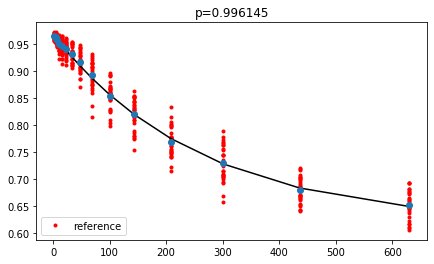

In [91]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label='reference')
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.title('p=%f'%p)
plt.show()

## gate

In [366]:
mlist, q_target, len_data, which = np.logspace(0.4,2.8,16,dtype=int), q6, 30, measure.offwhich[0]
dragcoef = 0.8/q_target.alpha/2/np.pi

await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
for gate in ['2','3','4','5','6','7'][:1]:
    job = Job(mr.RB_waveform, (q_target,measure,mlist,len_data,which,110e6,dragcoef,gate), tags=[q_target.q_name,gate],no_bar=True)
    n_RBw, pop_RBw = await job.done()
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=[])

Output()

Output()

Output()

<IPython.core.display.Javascript object>


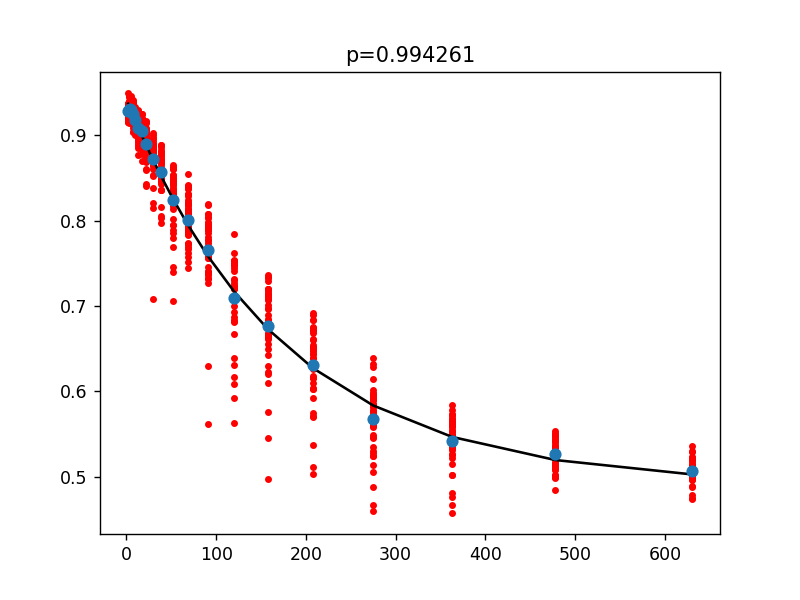

In [64]:
n, pop = n_RBw, pop_RBw
x = np.meshgrid(range(np.shape(pop)[1]),n)[1]
plt.figure(figsize=(7,4))
plt.plot(x.flatten(),pop.flatten(),'r.',label=gate)
plt.legend(loc='lower left')
x, y = n_RBw[:,0], np.abs(np.mean(pop,axis=1))
A,B,p = op.RB_Fit().fitRB(x,y)
z = A*p**x+B
plt.plot(x,z,'k')
plt.plot(x,y,'o')
plt.set_title('p=%f'%p)
plt.show()

In [70]:
Pref, Pgate, d = 0.9946, 0.994261, 2**(1)
Rgate = (1-Pgate/Pref)*(1-1/d)
Rgate

-0.003516601051131496

# 单比特tomo

In [551]:
q_target, which = q6, measure.onwhich
dragcoef = None
t_rabi = np.linspace(1,30,31)
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.tomo, (q_target,measure,t_rabi,which,dragcoef), tags=[q_target.q_name], max=len(t_rabi))
t_tomo, poplist = await job.done()

Output()

In [553]:
poplist

array([[0.4414557 , 0.68255538, 0.09434335],
       [0.44165348, 0.74643987, 0.14893196],
       [0.42464399, 0.84355222, 0.27650316],
       [0.44719146, 0.88627373, 0.40842563],
       [0.40051424, 0.89181171, 0.40150316],
       [0.38172468, 0.87440665, 0.58049842],
       [0.43908228, 0.7903481 , 0.7252769 ],
       [0.44481804, 0.71064082, 0.81863133],
       [0.38548259, 0.55439082, 0.89121835],
       [0.42780854, 0.42147943, 0.89339399],
       [0.47982595, 0.28322785, 0.84196994],
       [0.43413766, 0.17246835, 0.77907437],
       [0.45193829, 0.10324367, 0.65288766],
       [0.46677215, 0.05953323, 0.49545095],
       [0.45431171, 0.0820807 , 0.34572785],
       [0.47290348, 0.14102057, 0.23457278],
       [0.46756329, 0.23971519, 0.15268987],
       [0.47606804, 0.37321994, 0.0846519 ],
       [0.47448576, 0.51681171, 0.06784019],
       [0.45945411, 0.63073576, 0.09236551],
       [0.47883703, 0.75613133, 0.17780854],
       [0.47606804, 0.84177215, 0.28560127],
       [0.

In [554]:
data = [[1-2*j[i] for i in range(3)] for j in poplist]
data

[[0.11708860759493667, -0.3651107594936709, 0.8113132911392404],
 [0.11669303797468356, -0.4928797468354431, 0.7021360759493671],
 [0.15071202531645567, -0.6871044303797469, 0.446993670886076],
 [0.10561708860759489, -0.7725474683544304, 0.18314873417721522],
 [0.19897151898734178, -0.7836234177215189, 0.196993670886076],
 [0.23655063291139244, -0.7488132911392404, -0.160996835443038],
 [0.12183544303797467, -0.5806962025316456, -0.45055379746835444],
 [0.11036392405063289, -0.4212816455696202, -0.637262658227848],
 [0.22903481012658233, -0.10878164556962022, -0.7824367088607596],
 [0.1443829113924051, 0.15704113924050633, -0.7867879746835442],
 [0.04034810126582278, 0.43354430379746833, -0.6839398734177216],
 [0.13172468354430378, 0.6550632911392404, -0.5581487341772151],
 [0.096123417721519, 0.7935126582278481, -0.3057753164556962],
 [0.06645569620253167, 0.8809335443037974, 0.009098101265822778],
 [0.091376582278481, 0.8358386075949367, 0.30854430379746833],
 [0.054193037974683556, 

In [401]:
np.savez('z.npz',data=c)

In [284]:
x = [['I1','I2'],['Q1','Q2']]*2

In [288]:
[x[0]*2,x[1]*2]

[['I1', 'I2', 'I1', 'I2'], ['Q1', 'Q2', 'Q1', 'Q2']]

In [287]:
x

[['I1', 'I2'], ['Q1', 'Q2'], ['I1', 'I2'], ['Q1', 'Q2']]

In [270]:
import qulab.waveform_new as wn

In [276]:
cos = wn._basic_wave(wn.COS, 2*np.pi/10)
pulse = wn._add(wn._mul(cos, a), b)
pulse

((((), ()), (((4, 0, 0.6283185307179586),), (1,))), (0.54, 0.46))

In [275]:
a = wn._const(0.46)
b = wn._const(0.54)

In [286]:
t_lst = np.linspace(-90000,10000,250000)*1e-9
pulse = wn.hanning(10000/1e9)
wav = pulse(t_lst)

<IPython.core.display.Javascript object>


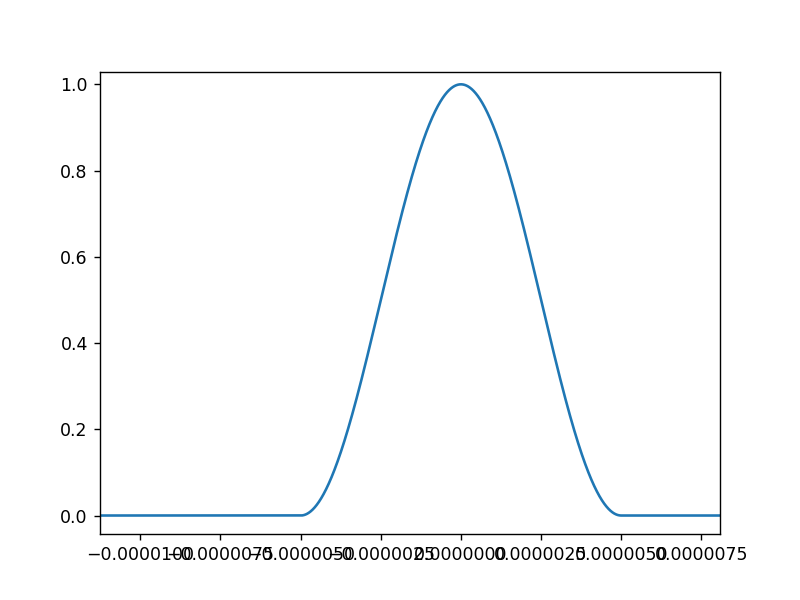

In [287]:
plt.figure()
plt.plot(t_lst,wav)